# Учимся обыгрывать казино: RL с блекджеком и Дастином Хоффманом.


## Часть первая, с блекджеком и стратегиями

Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.  

Правила блекджека достаточно просты; давайте начнём с самой базовой версии, которая реализована в OpenAI Gym: 
* численные значения карт равны от 2 до 10 для карт от двойки до десятки, 10 для валетов, дам и королей;  
* туз считается за 11 очков, если общая сумма карт на руке при этом не превосходит 21 (по-английски в этом случае говорят, что на руке есть usable ace), и за 1 очко, если превосходит;  
* игроку раздаются две карты, дилеру — одна в открытую и одна в закрытую;  
* игрок может совершать одно из двух действий:  
  - hit  — взять ещё одну карту;  
  - stand — не брать больше карт;  
* если сумма очков у игрока на руках больше 21, он проигрывает (bust);  
* если игрок выбирает stand с суммой не больше 21, дилер добирает карты, пока сумма карт в его руке меньше 17;
* после этого игрок выигрывает, если дилер либо превышает 21, либо получает сумму очков меньше, чем сумма очков у игрока; при равенстве очков объявляется ничья (ставка возвращается);  
* в исходных правилах есть ещё дополнительный бонус за natural blackjack: если игрок набирает 21 очко с раздачи, двумя картами, он выигрывает не +1, а +1.5 (полторы ставки).  
  
Именно этот простейший вариант блекджека реализован в OpenAI Gym:  
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

### 1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [1]:
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import tqdm

sns.set_style("whitegrid")
sns.set_palette("colorblind")
palette = sns.color_palette()
figsize = (15,8)
legend_fontsize = 16

from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=False)
# rc('text.latex',preamble=r'\usepackage[utf8]{inputenc}')
# rc('text.latex',preamble=r'\usepackage[russian]{babel}')
rc('figure', **{'dpi': 300})


import gym

In [2]:
class Agent:
    """Base class for agents"""
    def __init__(self, action_size):
        pass 

    def act(self, state):
        pass


class ThresholdAgent(Agent):
    """Agent acts depending on constant threshold"""
    def __init__(self, action_size, threshold):
        super().__init__(action_size)
        self.threshold = threshold
        self.action_size = action_size
    
    def act(self, state):
        if state[0] < self.threshold:
            action = 1
        else:
            action = 0
        return action
    
    
class EpsilonGreedyAgent(Agent):
    def __init__(self, action_size, agent, eps=0.1):
        super().__init__(action_size)
        self.agent = agent
        self.eps = eps
        self.action_size = action_size

    def act(self, state):
        if random.random() < self.eps:
            return random.randint(self.action_size)
        else:
            return self.agent.act(state)

In [5]:
env = gym.make('Blackjack-v1', natural=True)

In [83]:
def sample_games(agent, num_games=100_000, env=env):
    reward_list = []
    for _ in range(num_games):
        obs = env.reset()
        while True:
            action = agent.act(obs)
            obs, reward, done, info = env.step(action)
            if done:
                reward_list.append(reward)
                break
    return reward_list

In [7]:
mean_res = []
x_range = range(10, 22)
for threshold in x_range:
    agent = ThresholdAgent(2, threshold)
    res = np.mean(sample_games(agent, num_games=50_000))
    mean_res.append(res)
    print(f"For threshold {threshold} mean reward is {res}")

For threshold 10 mean reward is -0.1565
For threshold 11 mean reward is -0.13846
For threshold 12 mean reward is -0.1037
For threshold 13 mean reward is -0.09356
For threshold 14 mean reward is -0.08002
For threshold 15 mean reward is -0.0705
For threshold 16 mean reward is -0.07346
For threshold 17 mean reward is -0.08258
For threshold 18 mean reward is -0.1065
For threshold 19 mean reward is -0.20272
For threshold 20 mean reward is -0.35378
For threshold 21 mean reward is -0.66796


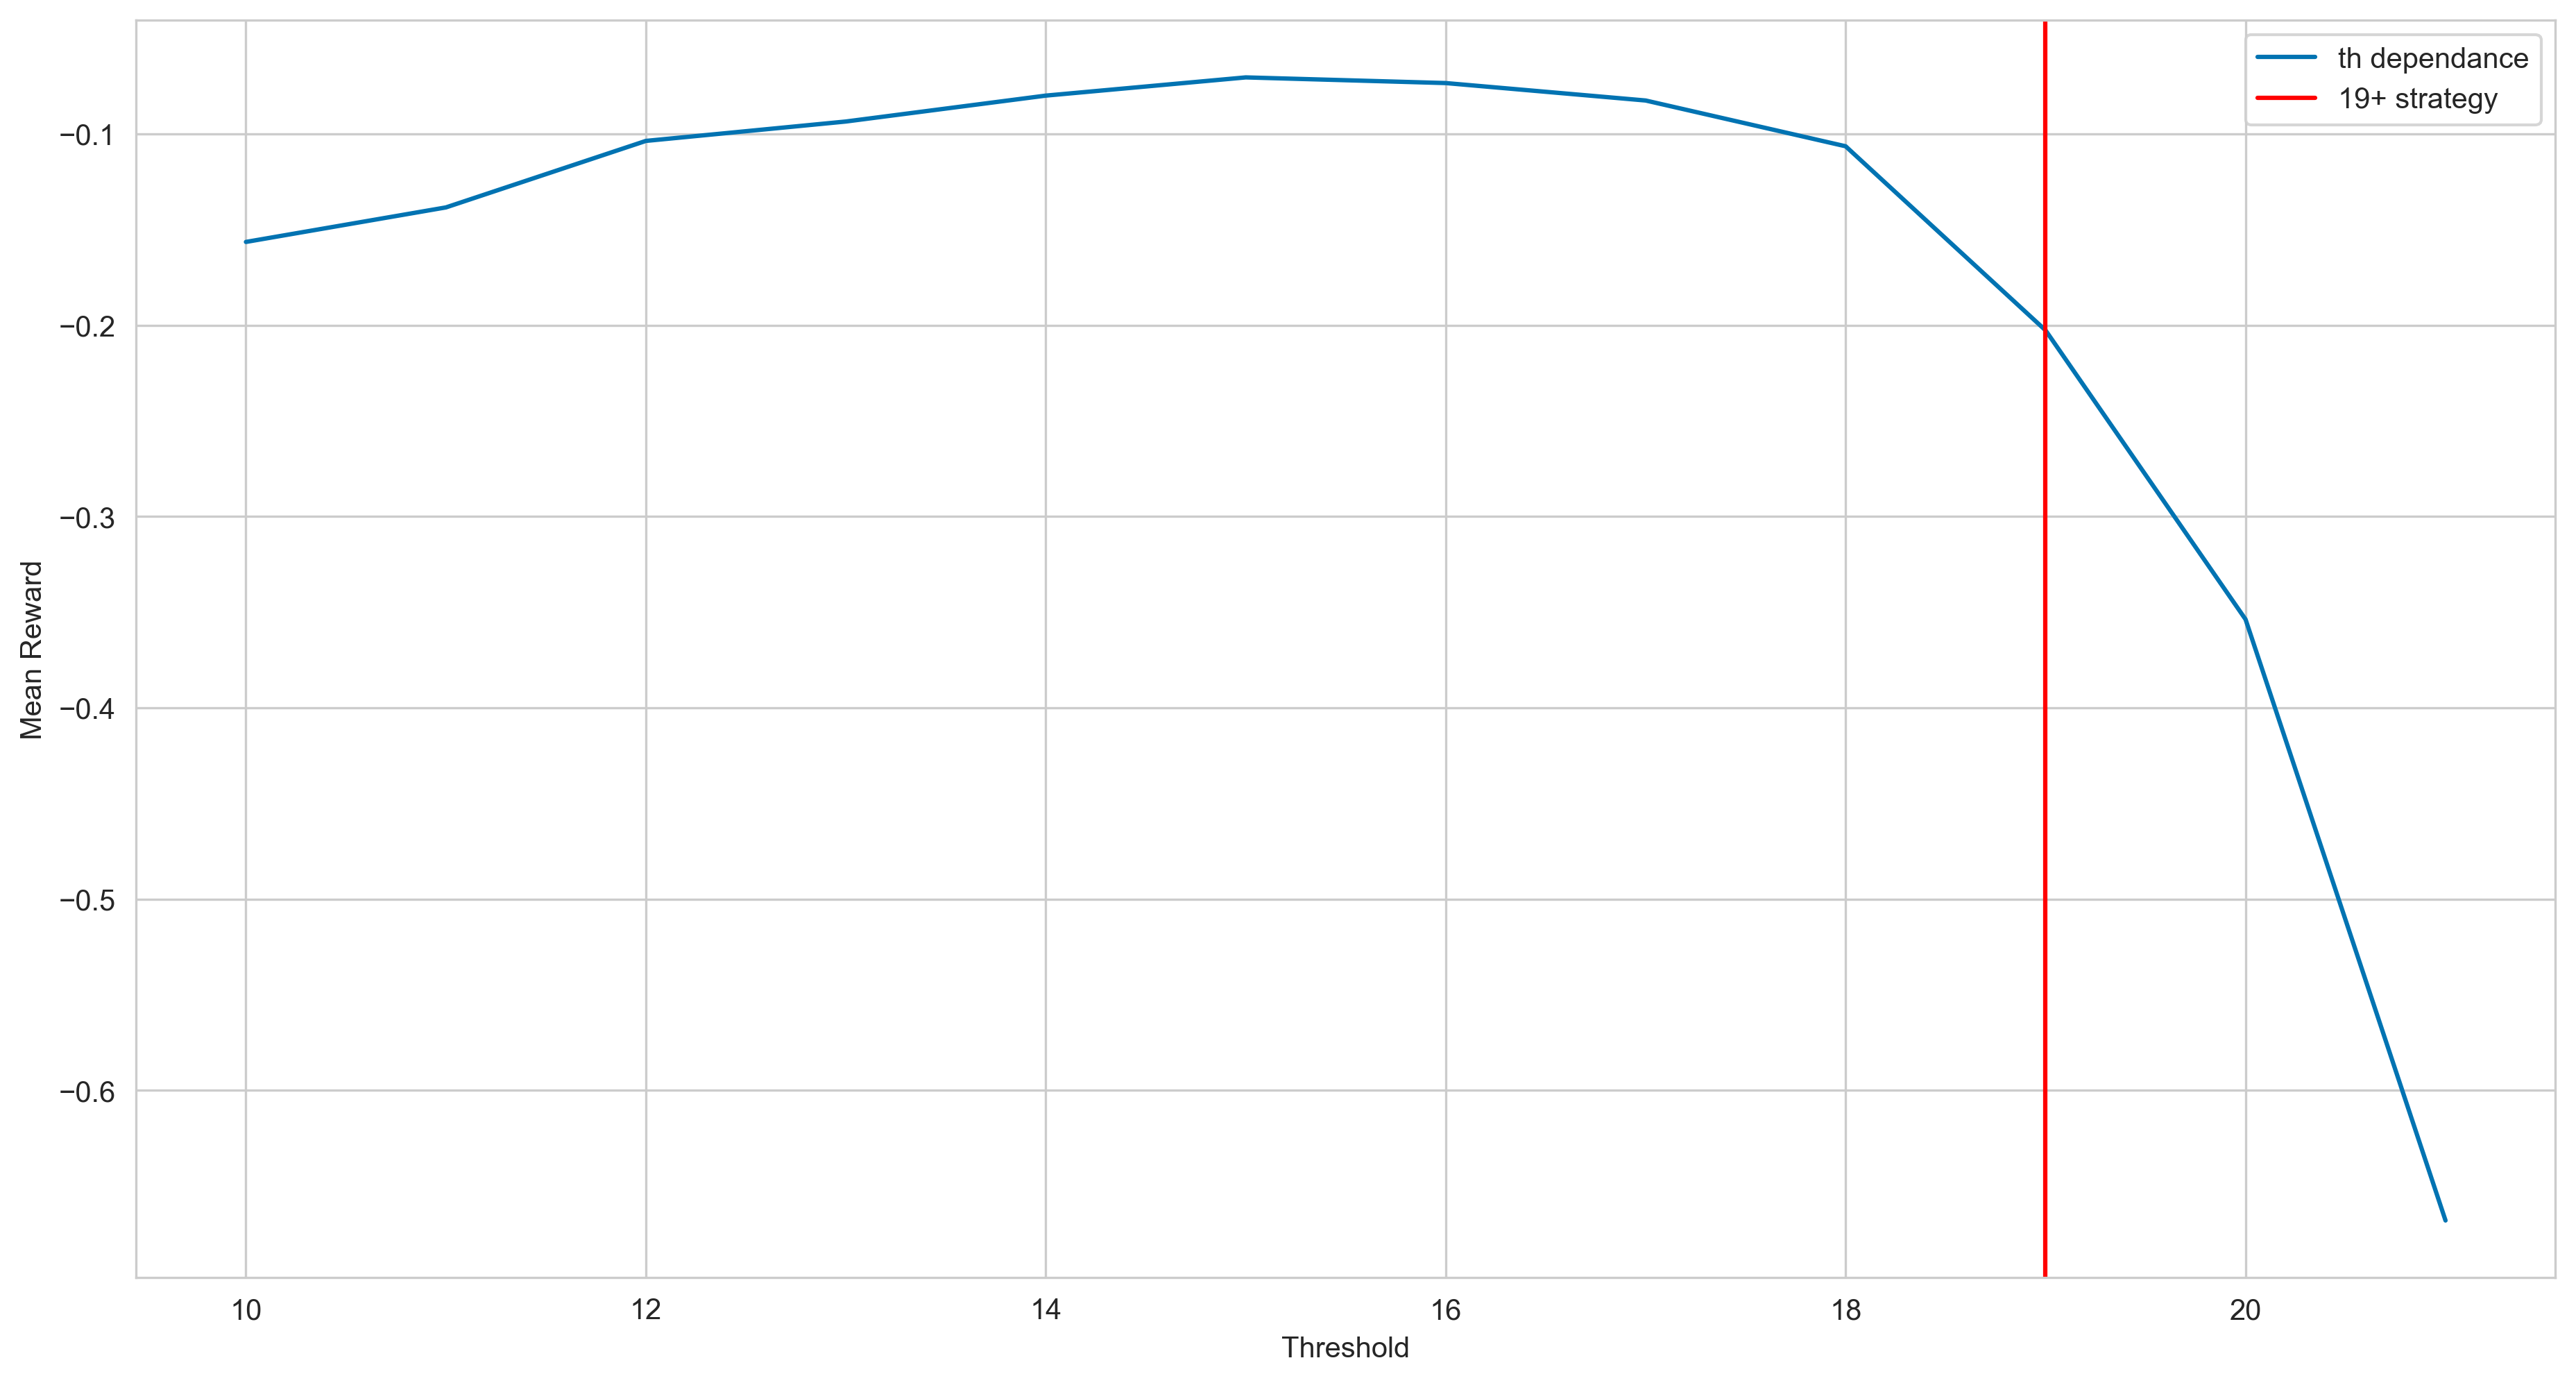

In [8]:
plt.figure(figsize=figsize)
plt.plot(x_range, mean_res, label="th dependance")
plt.axvline(19, color="red", label="19+ strategy")
plt.xlabel("Threshold")
plt.ylabel("Mean Reward")
plt.legend()
plt.show()

### 2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.   
### 3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

#### Monte-Carlo control с on-policy исследованием

##### Подготовительные функции

In [9]:
# constants
nA = 2
nS = 380

In [84]:
def collect_states(env, NUM_GAMES=10_000):
    states = set()
    for _ in range(NUM_GAMES):
        done = False
        observation = env.reset()
        states.add(observation)
        while not done:
            action = random.randint(0, nA - 1)
            observation, reward, done, _ = env.step(action)
            states.add(observation)
    return states

In [11]:
for _ in range(10):
    env = gym.make('Blackjack-v1', natural=True)
    states = collect_states(env)
    if len(states) == nS:
        break
len(states)

380

In [12]:
state_list = list(states)
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

In [13]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size, eps=0.1):
        super().__init__(action_size)
        self.eps = eps
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(action_size), states_size)
        self.Q = np.zeros((states_size, action_size))

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q=None):
        Q = Q if Q is not None else self.Q
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    
    def get_Q_by_R(self, R, Q_default=None):
        Q = Q_default if Q_default is not None else self.Q
        for s in range(self.states_size):
            for a in range(self.action_size):
                if len(R[s][a]) > 0:
                    Q[s][a] = np.mean(R[s][a])
        self.Q = Q
        return Q

In [14]:
def run_episode_actions(env, agent, eps=0.5):
    observation = env.reset()
    next_action = agent.act(observation) if random.random() > eps else random.randint(0, nA - 1)
    states, actions, rewards = [observation], [next_action], [0]
    for _ in range(1000):
        observation, reward, done, info = env.step(next_action)
        states.append(observation)
        next_action = agent.act(observation) if random.random() > eps else random.randint(0, nA - 1)
        actions.append(next_action)
        rewards.append(reward)
        if done:
            break
    return states, actions, rewards

def update_returns_actions(R, states, actions, rewards, gamma=1.0, R_all=None):
    state_first_visit = [-1 for _ in range(nS)]
    for t, state in enumerate(states):
        if state_first_visit[state_to_idx[state]] == -1:
            state_first_visit[state_to_idx[state]] = t
    g = 0
    if R_all is not None:
        _ = [R_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]
    if state_first_visit[state_to_idx[states[-1]]] == len(states)-1:
        R[state_to_idx[states[-1]]][actions[-1]].append(g)
        if R_all is not None:
            R_all[state_to_idx[states[t]]][actions[t]][-1] = g
    for t in range(len(states)-2, -1, -1):
        g =  g * gamma + rewards[t+1]
        if state_first_visit[state_to_idx[states[t]]] == t:
            R[state_to_idx[states[t]]][actions[t]].append(g)
            if R_all is not None:
                R_all[state_to_idx[states[t]]][actions[t]][-1] = g
    return R, R_all

In [48]:
def plot_rewards(reward_list, period=1_000):
    x_range = np.arange(len(reward_list)) * period
    plt.figure(figsize=figsize)
    plt.plot(x_range, reward_list)
    plt.xlabel("Games played with learning")
    plt.ylabel(f"Mean Reward over {period} games")
    plt.show()

def plot_rewards_rolling(reward_list, period=1_000, roll=10):
    x_range = np.arange(len(reward_list)) * period
    plt.figure(figsize=figsize)
    plt.plot(x_range, reward_list, color="cyan", label="row")
    plt.plot(x_range, pd.Series(reward_list).rolling(roll).mean(), color="blue", label=f"rolling({roll}) mean")
    plt.xlabel("Games played with learning")
    plt.ylabel(f"Mean Reward over {period} games")
    plt.legend()
    plt.show()

##### Обучение

In [17]:
def mc_on_policy_train(env, agent, init_episodes=5_000, total_episodes=100_000, gamma=1,
                       eps=0.2, n_check=1_000, num_games=1_000):

    R, R_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ], [ [ [] for _ in range(nA) ] for _ in range(nS) ]

    reward_list = []

    Q = agent.Q
    pi = agent.pi

    for _ in range(init_episodes):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        R, R_all = update_returns_actions(R, states, actions, rewards, gamma=gamma, R_all=R_all)
        Q = agent.get_Q_by_R(R, Q_default=agent.Q)
        pi = agent.update_pi(agent.Q)
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games))
            reward_list.append(mean_reward)
            
    return agent, reward_list

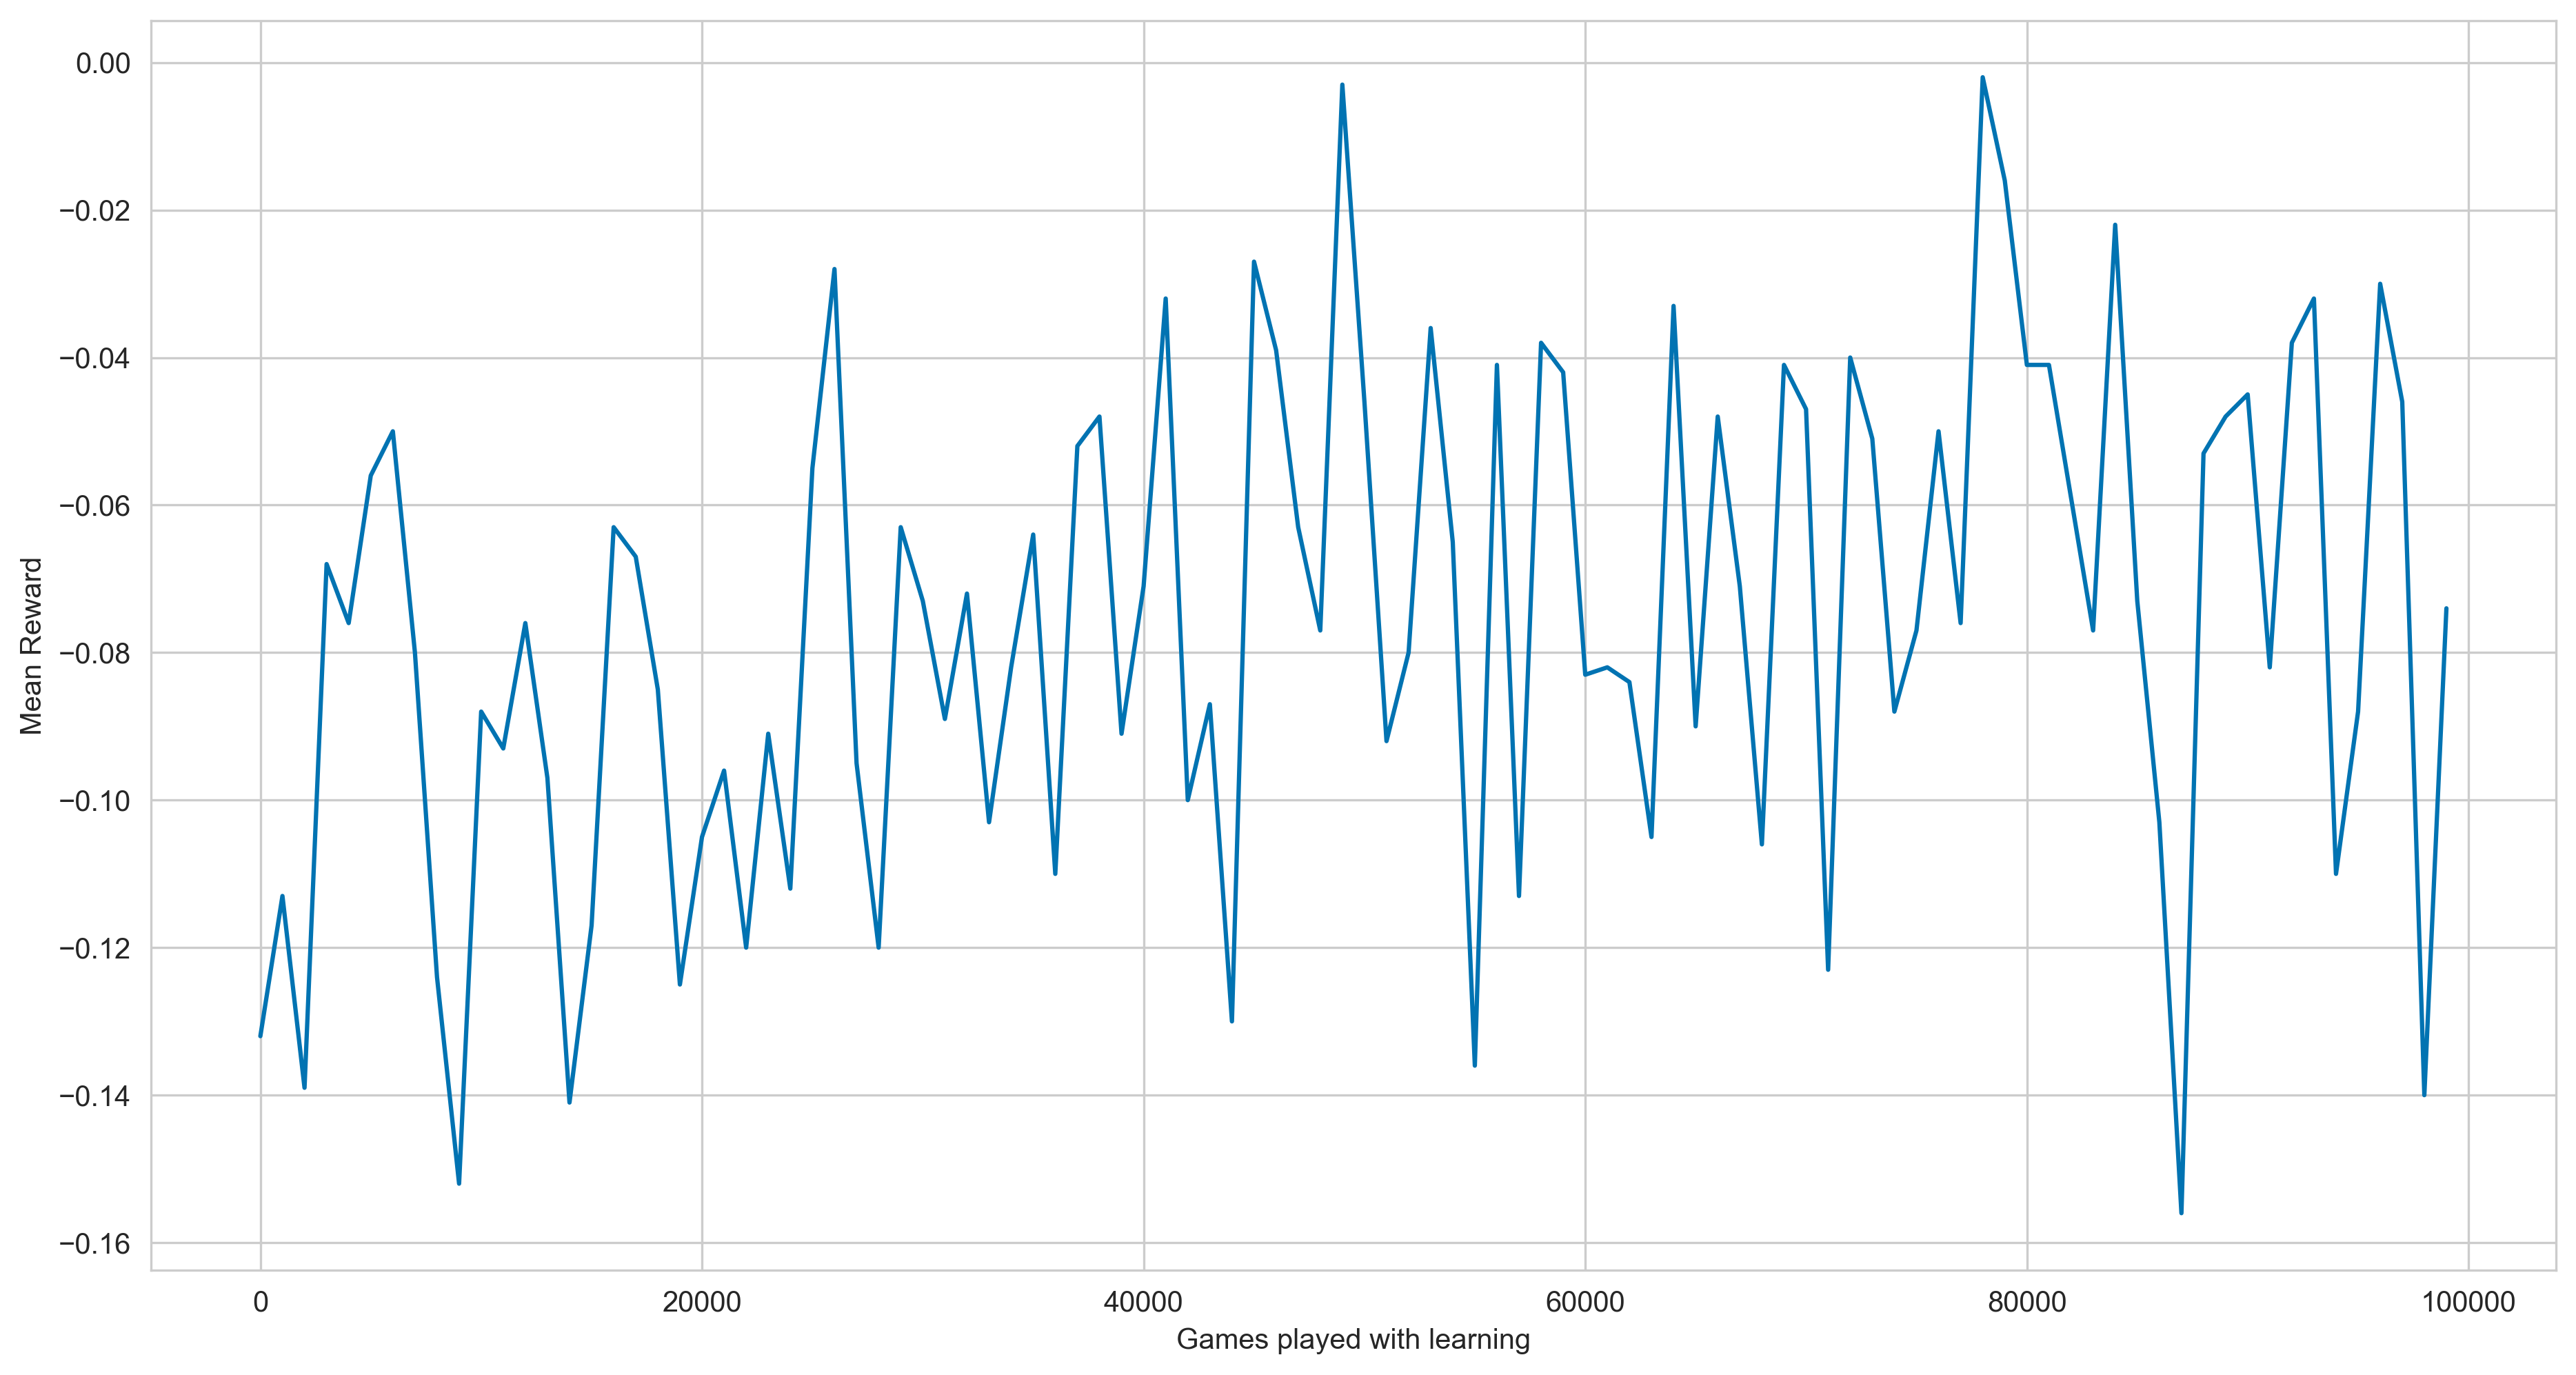

Final agent got mean reward -0.062 for 10000 games


In [20]:
env = gym.make('Blackjack-v1', natural=True)
env._max_episode_steps = 10000
init_episodes, total_episodes = 10_000, 100_000
num_games=10_000
n_check = 1_000

gamma = 1
eps = 0.1

agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

agent, reward_list = mc_on_policy_train(env, agent, init_episodes, total_episodes, gamma, eps, n_check)

plot_rewards(reward_list, n_check)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Final agent got mean reward {res:.3f} for {num_games} games")

env.close()

#### Monte Carlo control offpolicy

In [21]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(action_size), states_size)

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q):
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    

In [22]:
def update_lists(s, a, g, w, Q, C, Q_all):
    s = state_to_idx[s]
    C[s][a] = C[s][a] + w
    Q[s][a] = Q[s][a] + (g - Q[s][a]) * w / C[s][a]
    if Q_all is not None:
        Q_all[s][a][-1] = g


def update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards, epsilon=0.1, gamma=1.0, Q_all=None):
    g, w, prob_best_action = 0., 1., 1 - (nA-1) * epsilon / nA
    if Q_all is not None:
        _ = [Q_all[s][a].append(np.nan) for a in range(nA) for s in range(nS)]

    # Обновляем функции для последнего хода
    update_lists(states[-1], actions[-1], g, w, Q, C, Q_all)
    
    for t in range(len(states)-2, -1, -1):
        # Если действие не соответствует лучшей стратегии, дальше не надо смотреть
        if actions[t+1] != pi[state_to_idx[states[t+1]]]:
            break
            
        # Обновляем веса и return
        w = w / ( prob_best_action )
        g =  g * gamma + rewards[t+1]
        
        # Обновляем функции
        update_lists(states[t], actions[t], g, w, Q, C, Q_all)
    return Q, C, Q_all

In [39]:
# def mc_off_policy_train(env, agent, total_episodes=100_000, gamma=1, eps=0.2):

#     Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

#     reward_list = []

#     Q = np.zeros((nS, nA))
#     pi = agent.update_pi(Q)

#     C = np.zeros((nS, nA), dtype=float)

#     for _ in range(total_episodes):
#         states, actions, rewards = run_episode_actions(env, agent, eps)
#         Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards,
#                                                           epsilon=eps, gamma=gamma, Q_all=Q_all)
#         pi = agent.update_pi(Q)
#         mean_reward = np.mean(sample_games(agent, num_games=1_000))
#         reward_list.append(mean_reward)
    
#     return agent, reward_list

In [93]:
def mc_off_policy_train(env, agent, total_episodes=100_000, gamma=1, eps=0.2, n_check=1_000, num_games=1_000):

    Q_all = [ [ [] for _ in range(nA) ] for _ in range(nS) ]

    reward_list = []

    Q = np.zeros((nS, nA))
    pi = agent.update_pi(Q)

    C = np.zeros((nS, nA), dtype=float)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        states, actions, rewards = run_episode_actions(env, agent, eps)
        Q, C, Q_all = update_returns_actions_offpolicy_MC(Q, C, pi, states, actions, rewards,
                                                          epsilon=eps, gamma=gamma, Q_all=Q_all)
        pi = agent.update_pi(Q)
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games))
            reward_list.append(mean_reward)
            
    return agent, reward_list

<ipython-input-23-6404891ddc66>:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for n in tqdm.tqdm_notebook(range(total_episodes)):


  0%|          | 0/100000 [00:00<?, ?it/s]

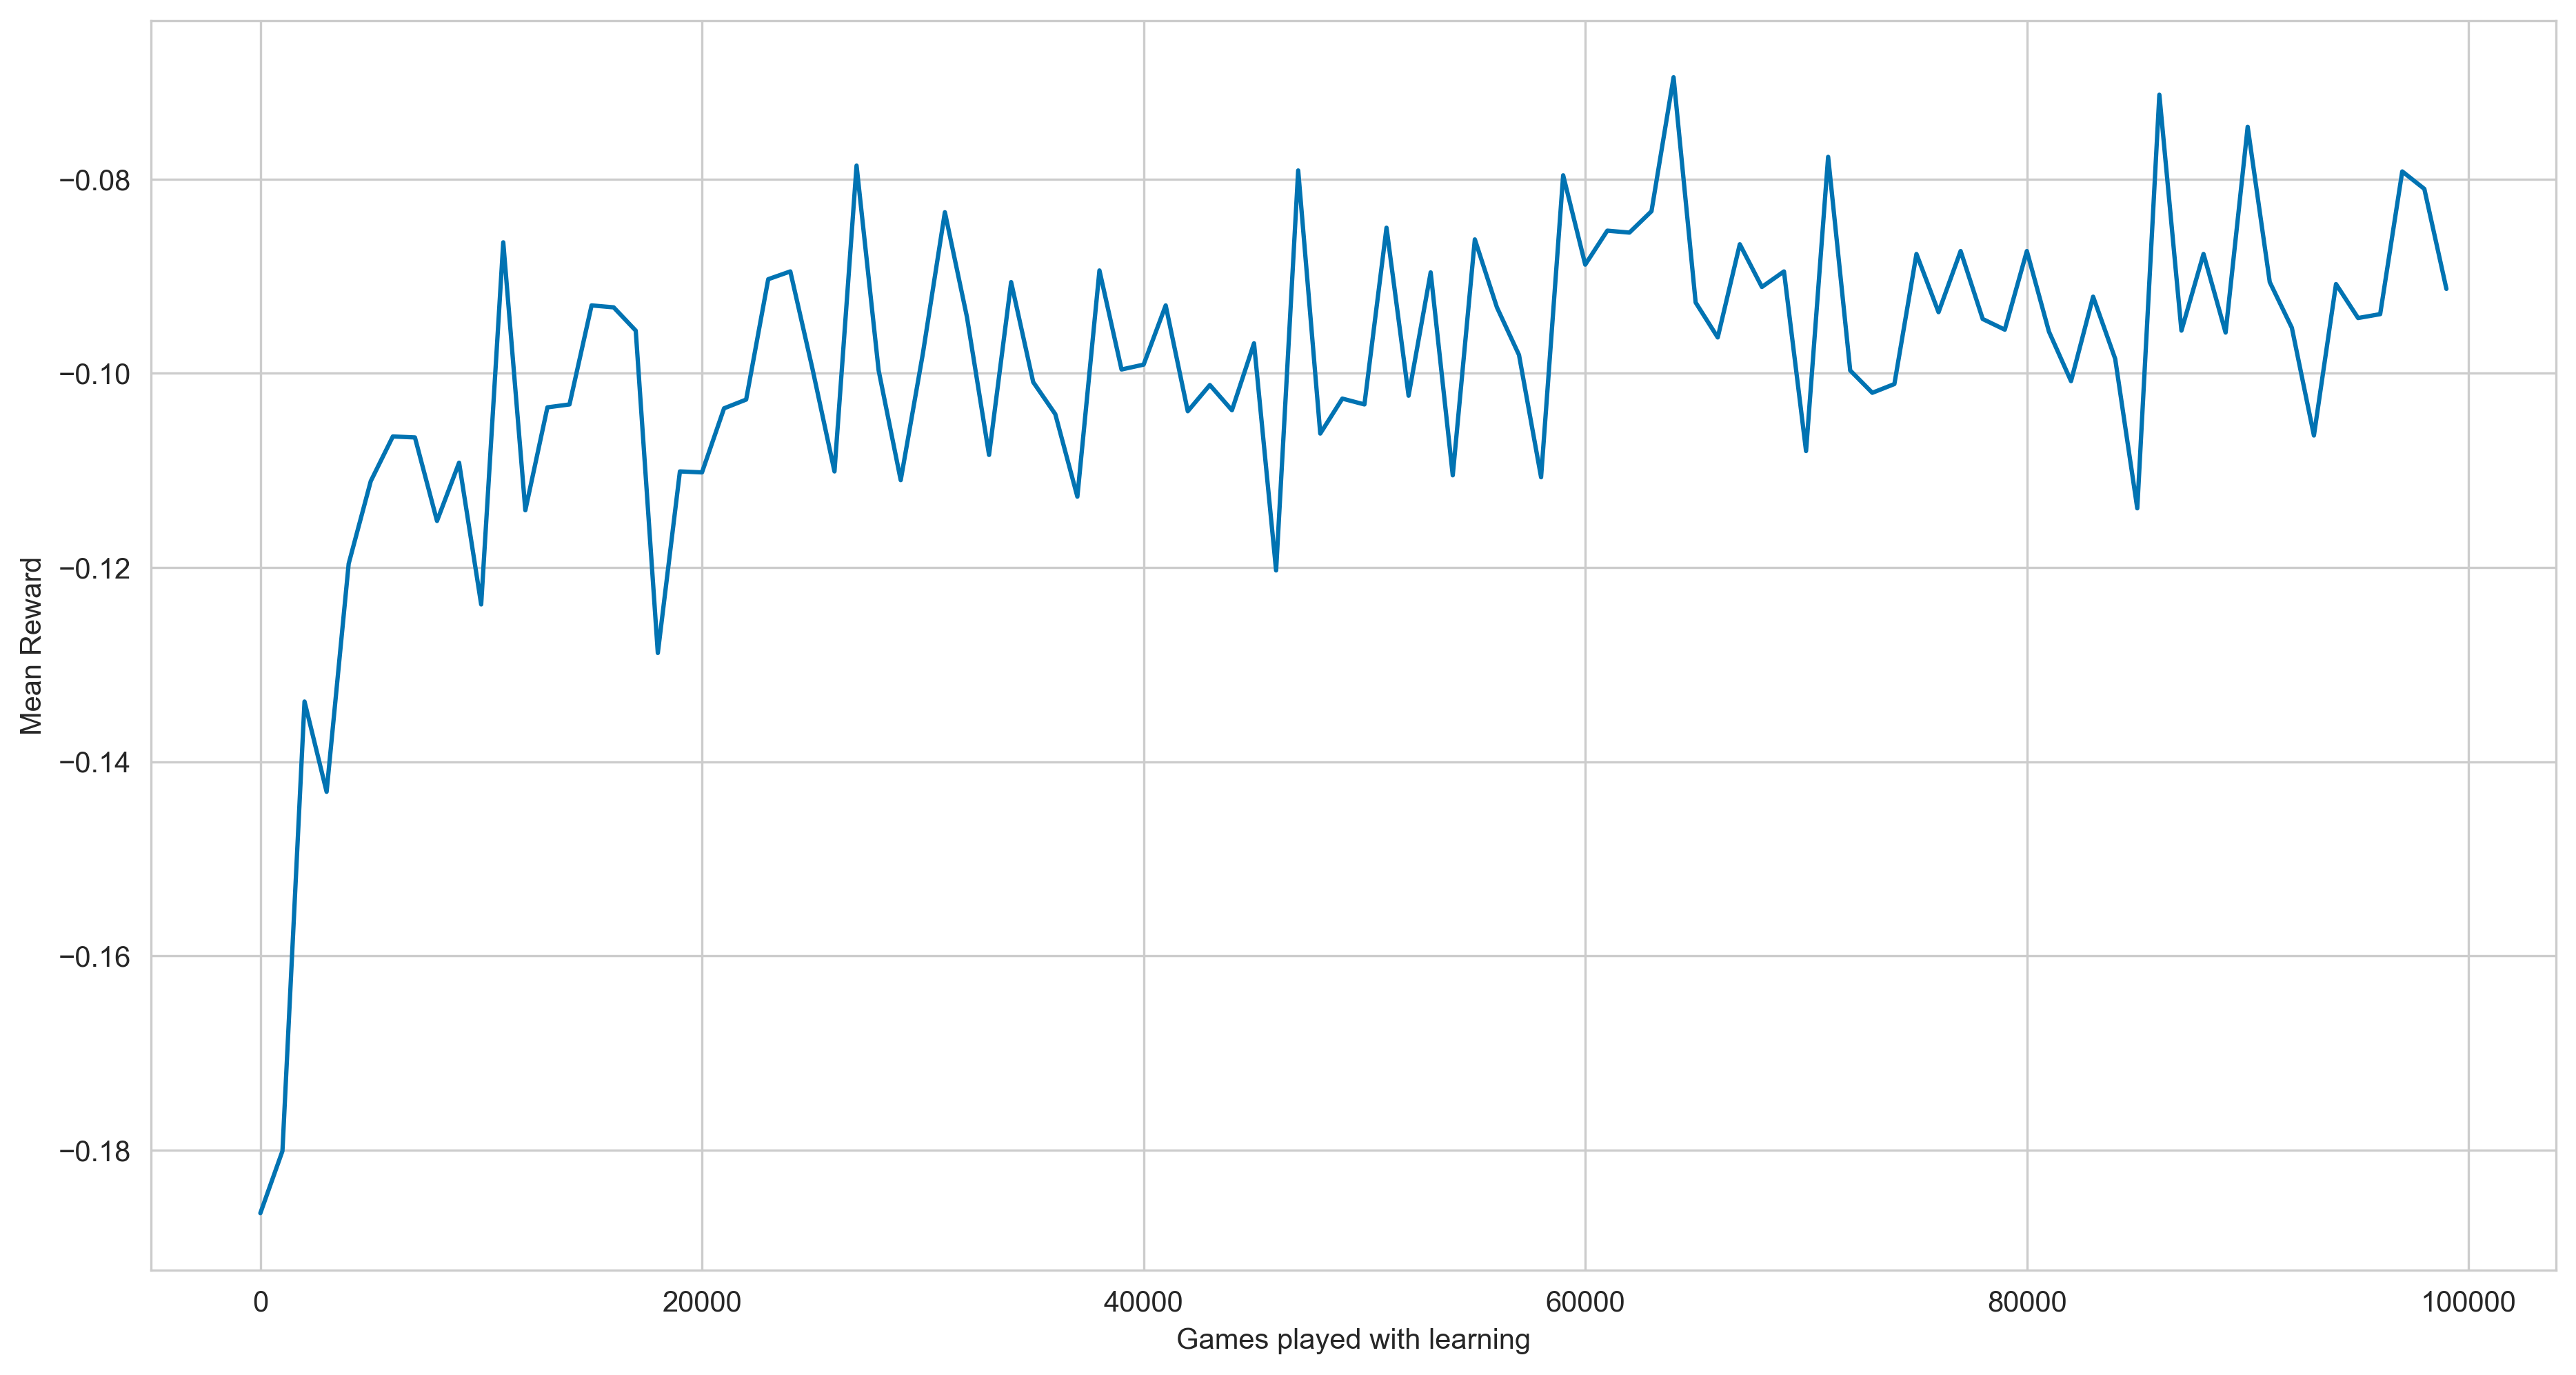

Final agent got mean reward -0.089 for 10000 games


In [24]:
agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.2

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards(reward_list, period)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Final agent got mean reward {res:.3f} for {num_games} games")

env.close()

#### Q-Learning

In [99]:
class DeterministicPolicyAgent(Agent):
    def __init__(self, action_size, states_size):
        super().__init__(action_size)
        self.action_size = action_size
        self.states_size = states_size
        self.pi = np.random.choice(np.arange(0, action_size), states_size)

    def act(self, state):
        return self.pi[state_to_idx[state]]
    
    def update_pi(self, Q):
        self.pi = np.argmax(Q, axis=-1)
        return self.pi
    

In [100]:
def Q_learning_episode(env, agent, Q, alpha=0.05, epsilon=0.0, gamma=0.9):
    observation = env.reset()
    s = state_to_idx[observation]
    a = agent.act(observation) if random.random() > epsilon else random.randint(0, nA - 1)
    for _ in range(1000):
        observation, reward, done, info = env.step(a)
        s_prime = state_to_idx[observation]
        a_prime = agent.act(observation) if random.random() > epsilon else random.randint(0, nA - 1)
#         s_prime, a_prime = env.env.s, pi[env.env.s] if np.random.rand() > epsilon else np.random.randint(nA)
        Q[s][a] = Q[s][a] + alpha * (reward + gamma * np.max( Q[s_prime] ) - Q[s][a])
        s, a = s_prime, a_prime
        if done:
            break
    return reward

In [101]:
def Q_learning_train(env, agent, total_episodes=1_000_000, gamma=1, eps=0.2, alpha=0.1,
                     n_check=1000, num_games=1_000):

#     Q_hist_Qlearn = [ ]
    reward_list = []

    Q = np.zeros((nS, nA))
    pi = agent.update_pi(Q)

    for n in tqdm.notebook.tqdm(range(total_episodes)):
        reward = Q_learning_episode(env, agent, Q, alpha=alpha, epsilon=eps, gamma=gamma)
        pi = agent.update_pi(Q)
#         Q_hist_Qlearn.append(np.copy(Q))
        if n % n_check == 0:
            mean_reward = np.mean(sample_games(agent, num_games=num_games))
            reward_list.append(mean_reward)
    
    return agent, reward_list

  0%|          | 0/200000 [00:00<?, ?it/s]

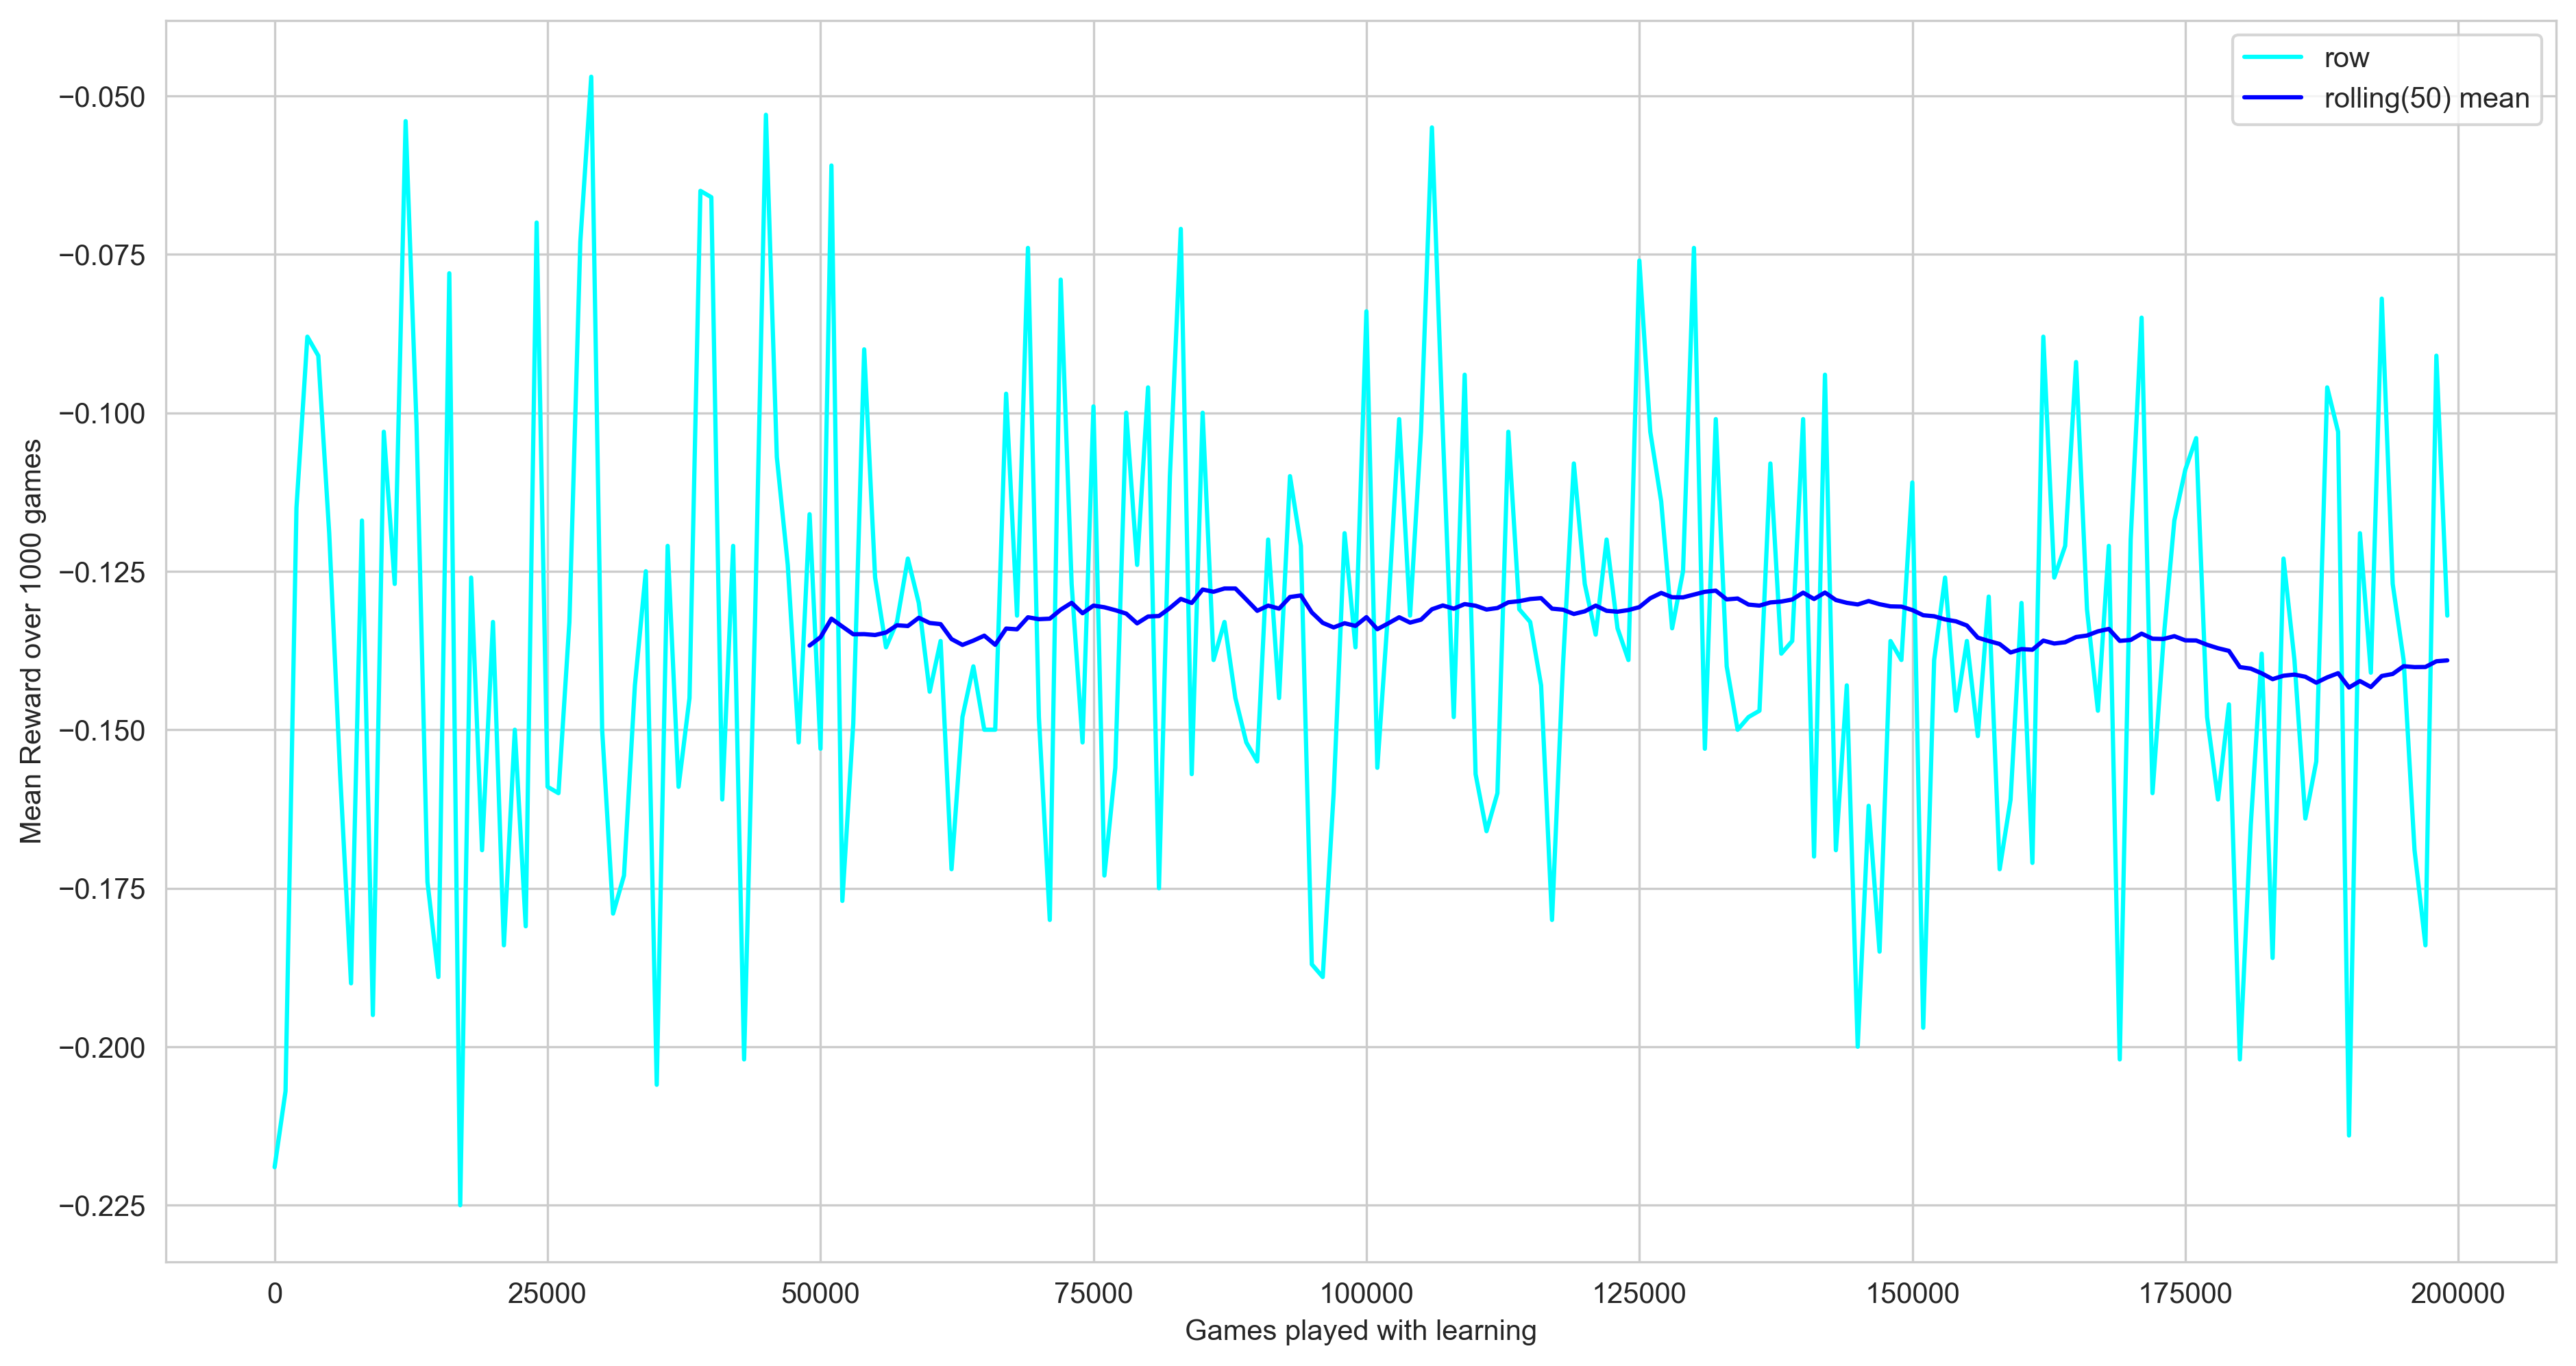

Final agent got mean reward -0.141 for 10000 games


In [53]:
agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
gamma = 1
eps = 0.2
alpha = 0.1

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Final agent got mean reward {res:.3f} for {num_games_outer} games")

env.close()

  0%|          | 0/200000 [00:00<?, ?it/s]

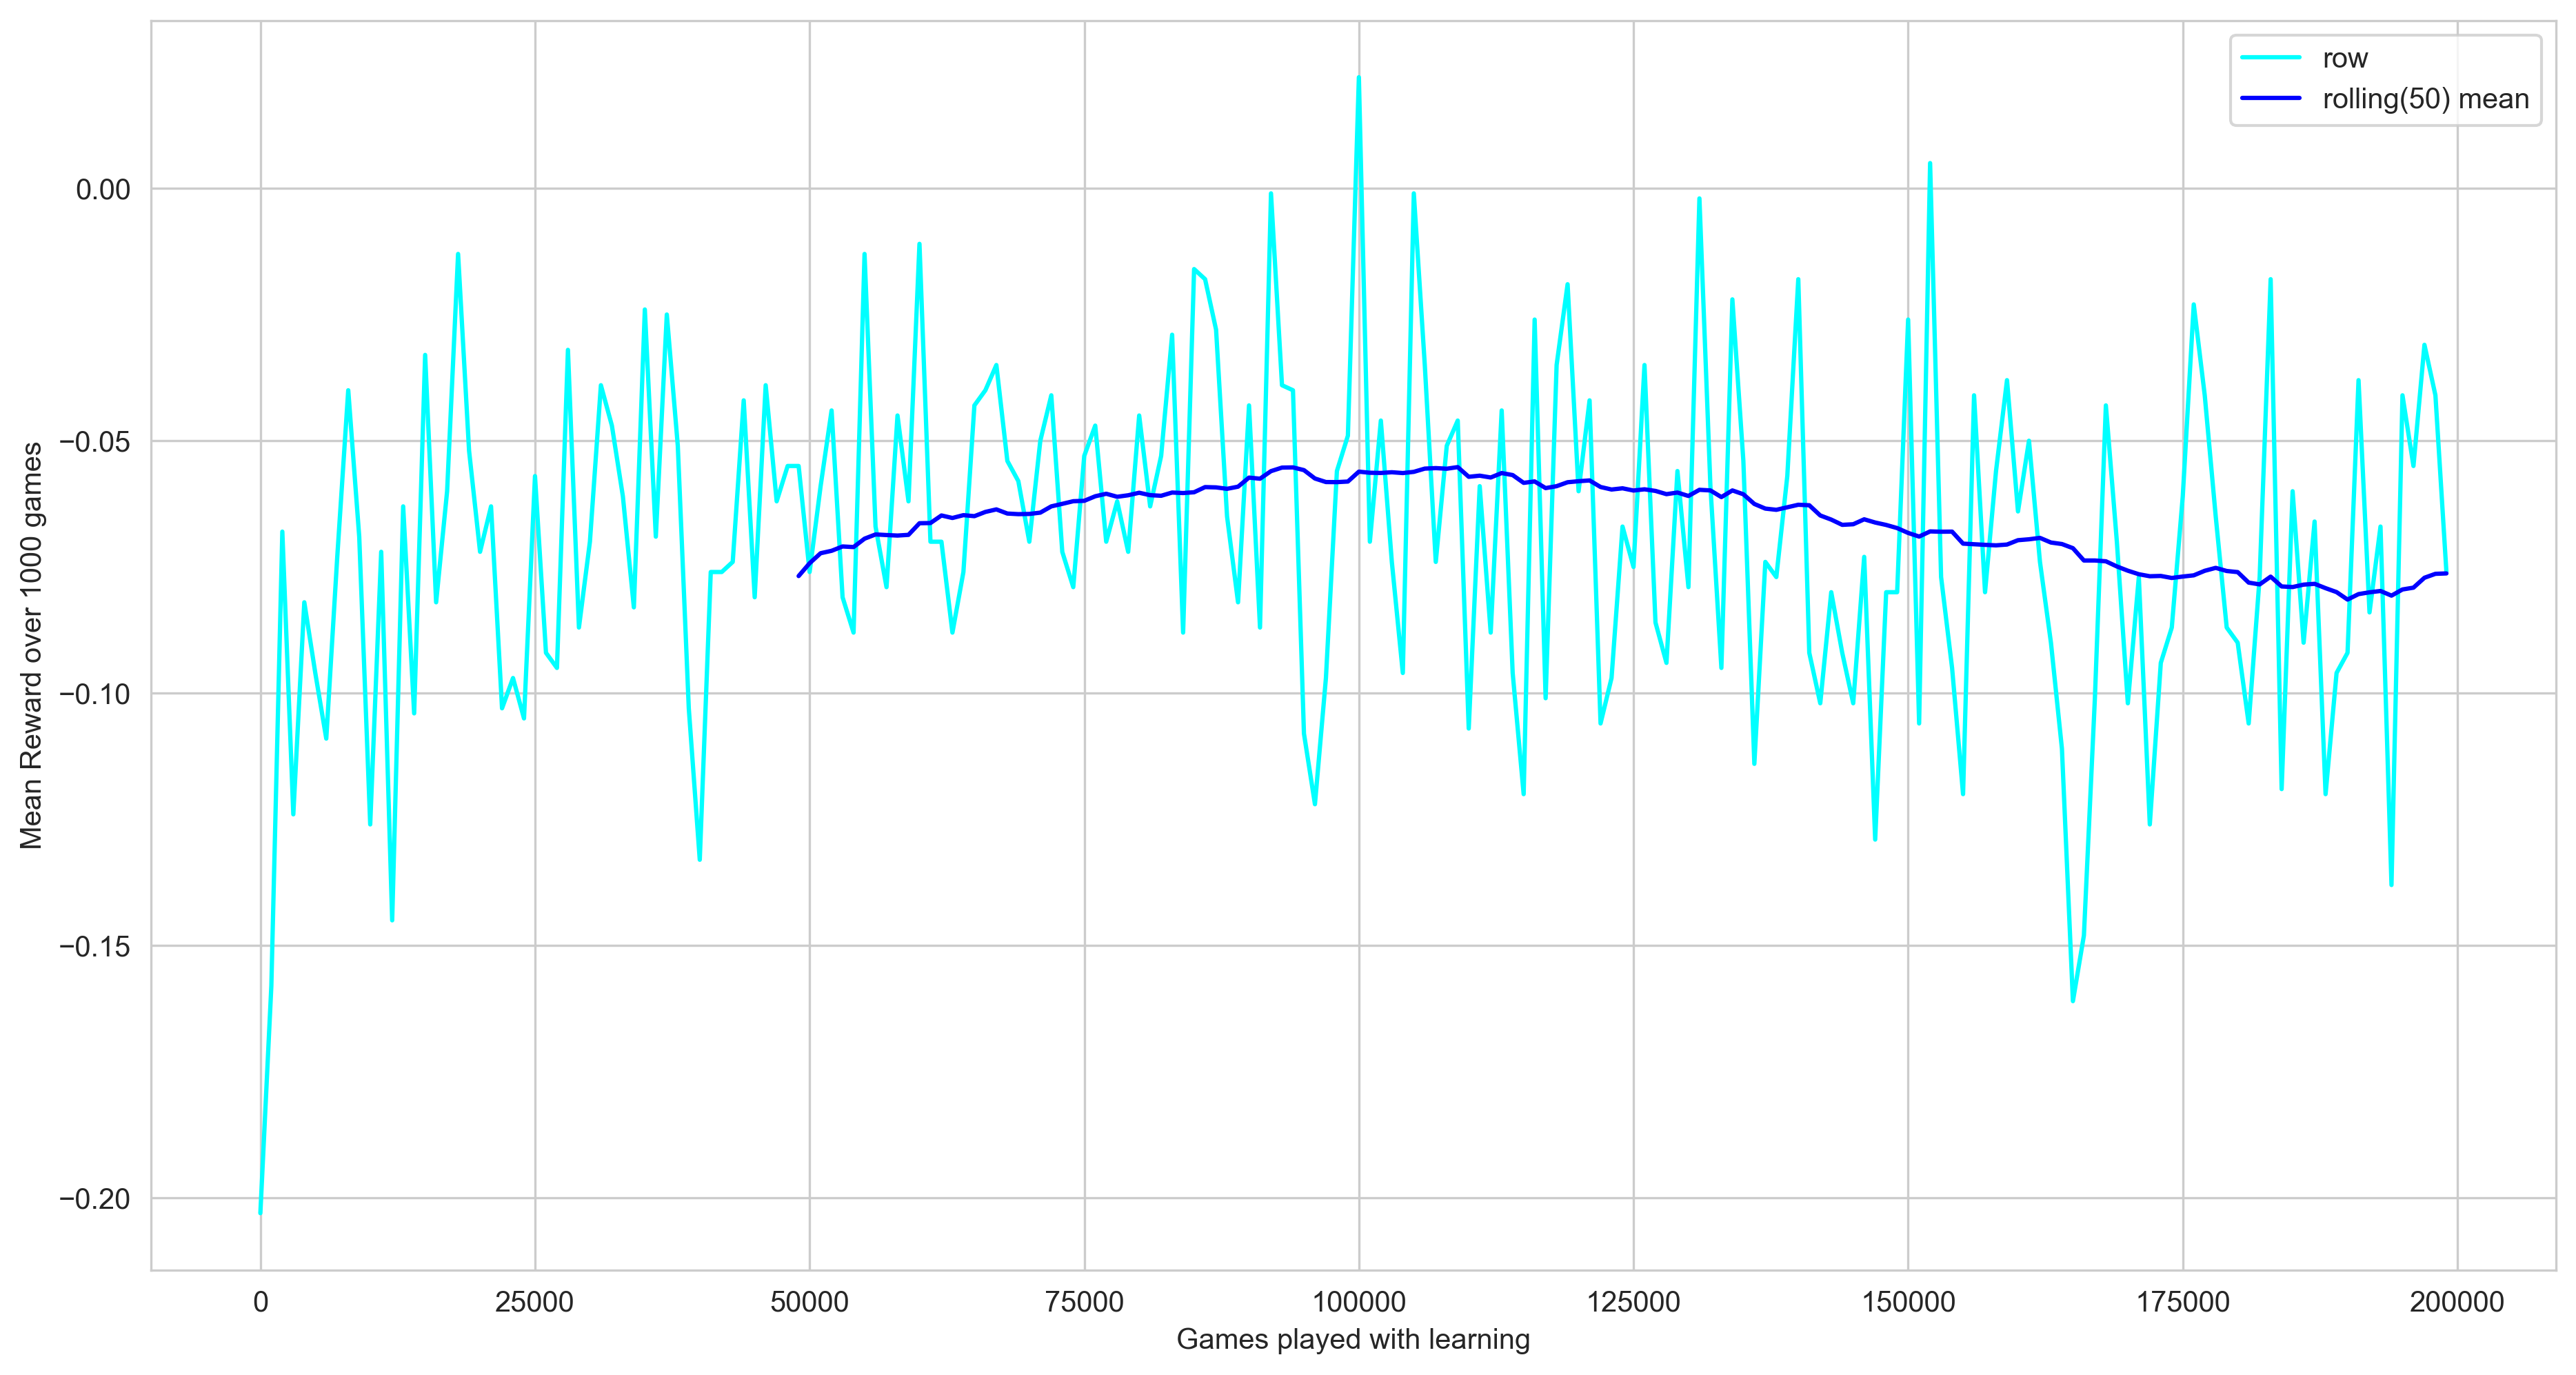

Final agent got mean reward -0.063 for 10000 games


In [56]:
agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
gamma = 1
eps = 0.8
alpha = 0.001

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Final agent got mean reward {res:.3f} for {num_games_outer} games")

env.close()

  0%|          | 0/200000 [00:00<?, ?it/s]

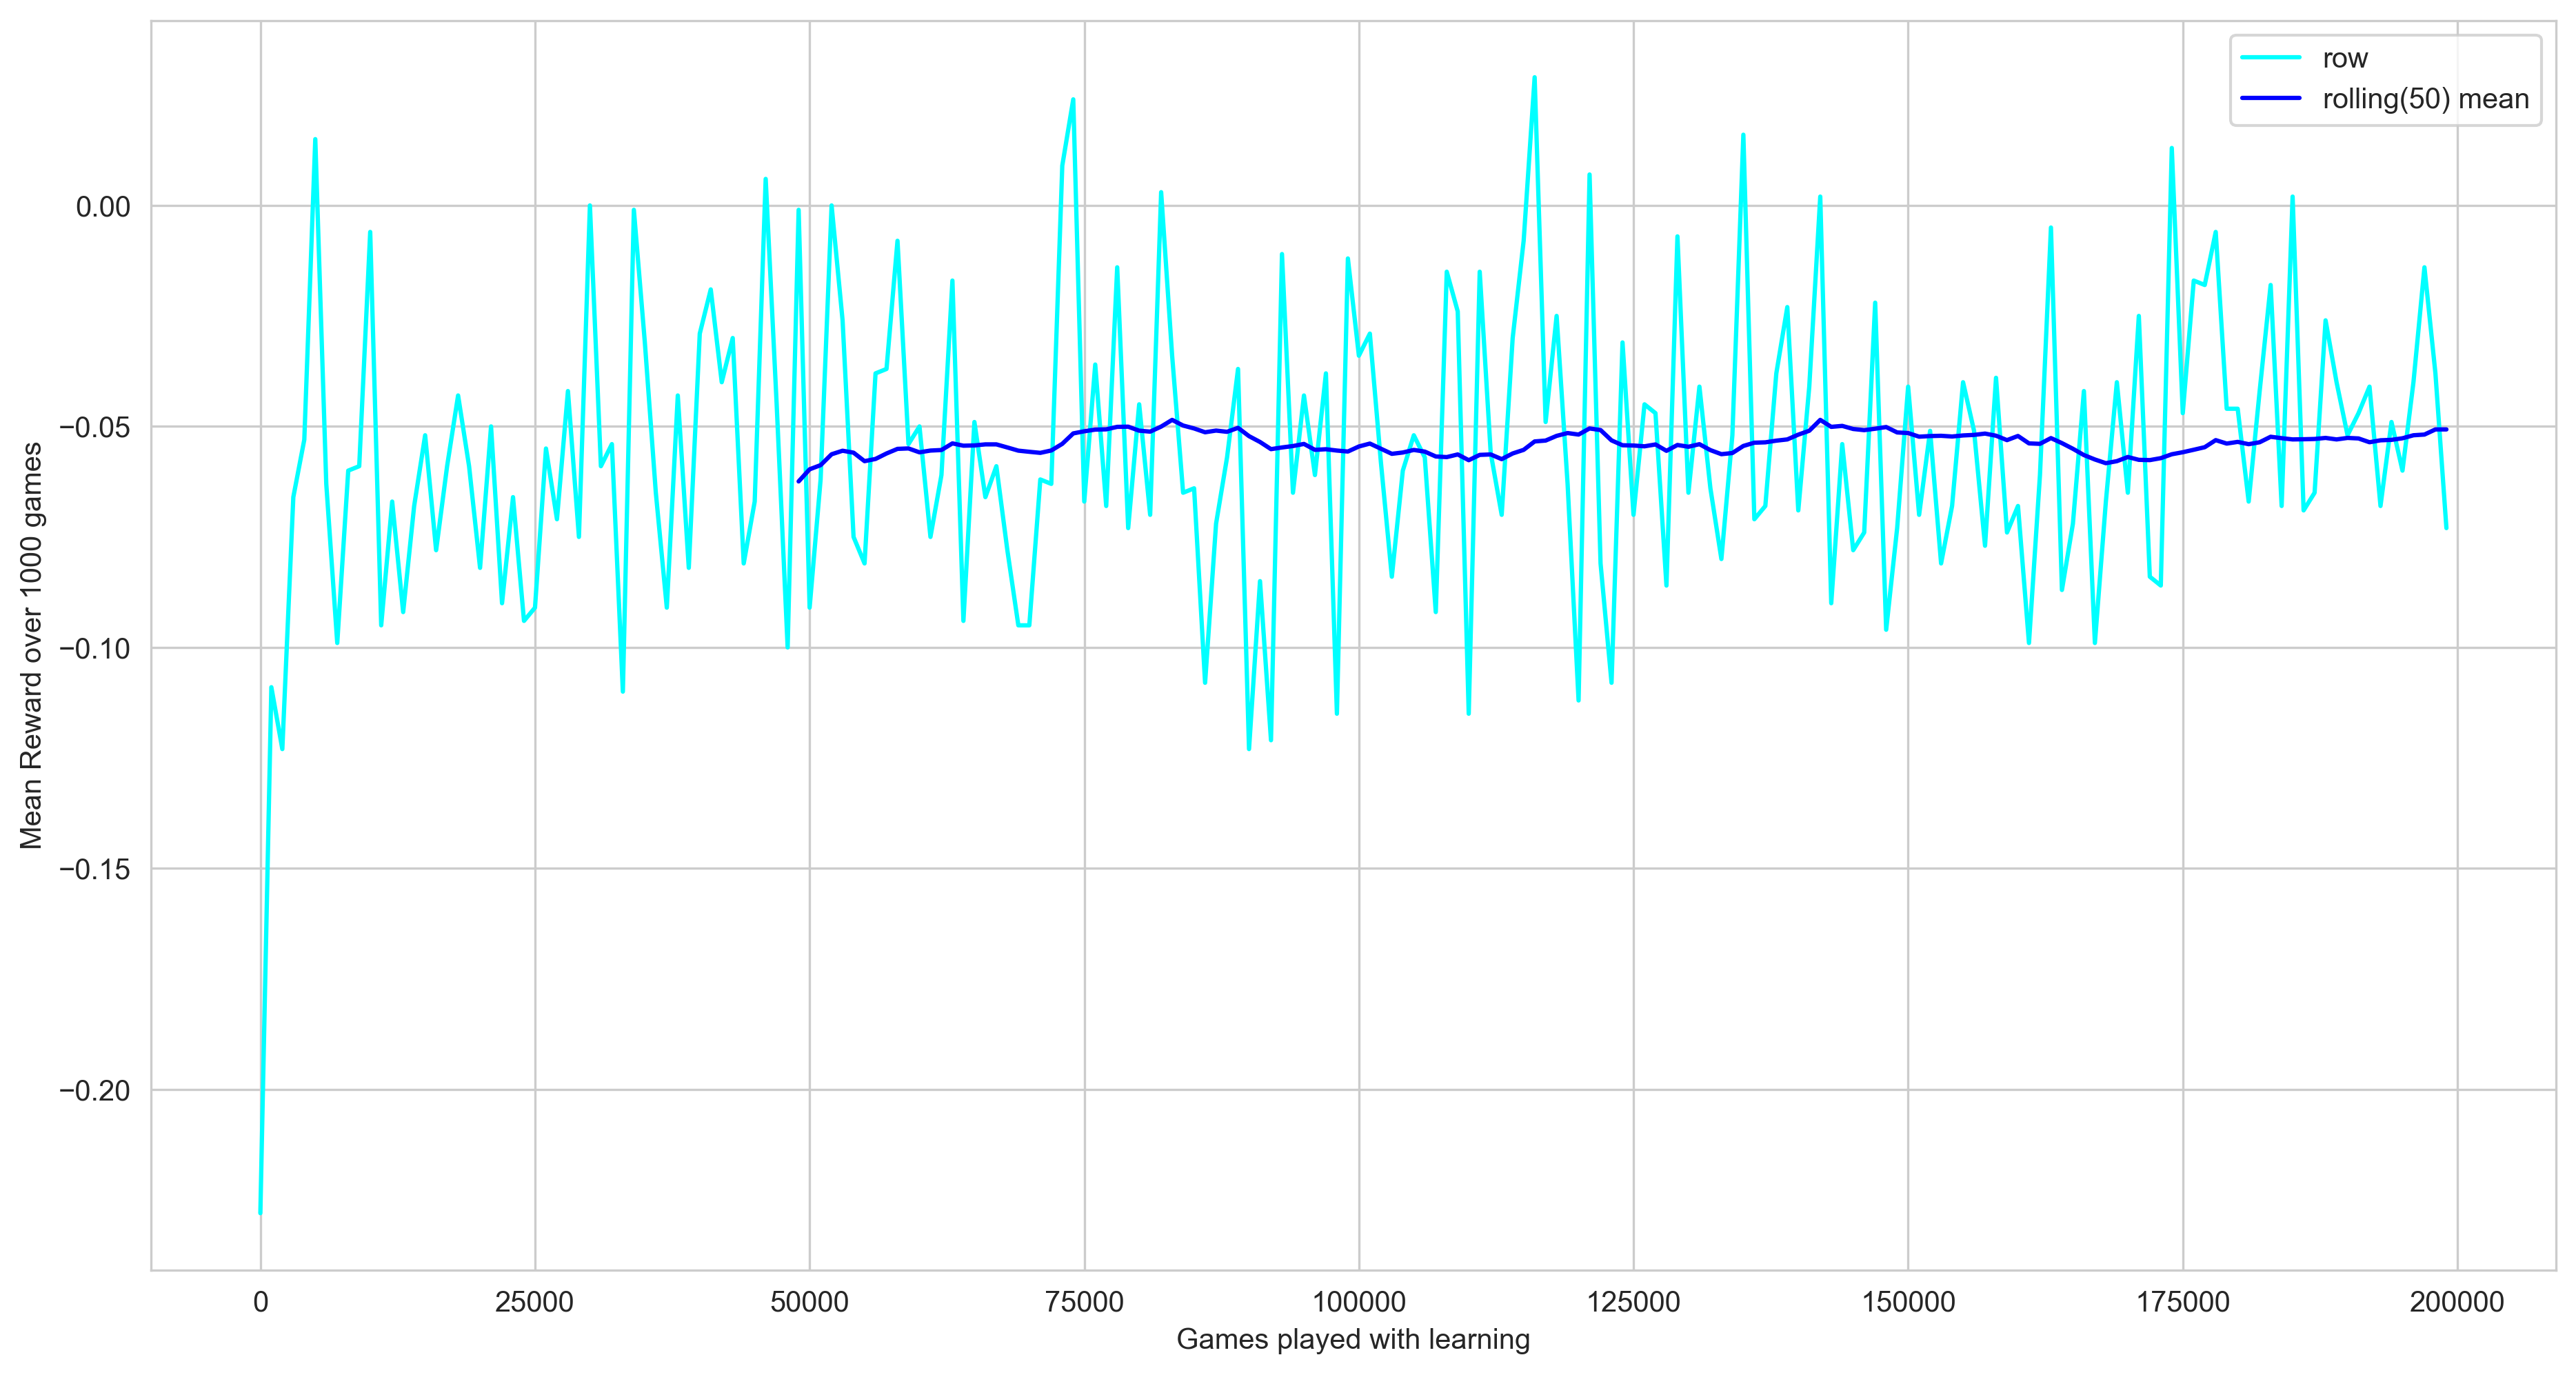

Final agent got mean reward -0.055 for 10000 games


In [57]:
agent = DeterministicPolicyAgent(action_size=2, states_size=len(state_list))

env = gym.make('Blackjack-v1', natural=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
gamma = 1
eps = 0.9
alpha = 0.0005

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Final agent got mean reward {res:.3f} for {num_games_outer} games")

env.close()

## Часть вторая, удвоенная

В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится.
Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными,
а на самом деле у игрока есть ещё и другие возможности. Реализовывать __split__ может оказаться непросто,
поэтому давайте ограничимся удвоением ставки.  
Итак, у игрока появляется дополнительное действие:  
- __double__ — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

### 4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.

In [121]:
from BlackJackDouble import BlackjackDoubleEnv
env = BlackjackDoubleEnv(natural=True, double=True)

In [122]:
# example
print(env.reset())
print(env.step(2))

(17, 2, False)
((27, 2, False), -2.0, True, {})


### 5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

In [118]:
# constants
nA = 3
nS = 380

In [123]:
for _ in range(10):
    env = BlackjackDoubleEnv(natural=True, double=True)
    states = collect_states(env, NUM_GAMES=30_000)
    if len(states) == nS:
        break
len(states)

380

In [90]:
state_list = list(states)
state_to_idx = {s: i for i, s in enumerate(state_list)}
idx_to_state = {i: s for i, s in enumerate(state_list)}

  0%|          | 0/200000 [00:00<?, ?it/s]

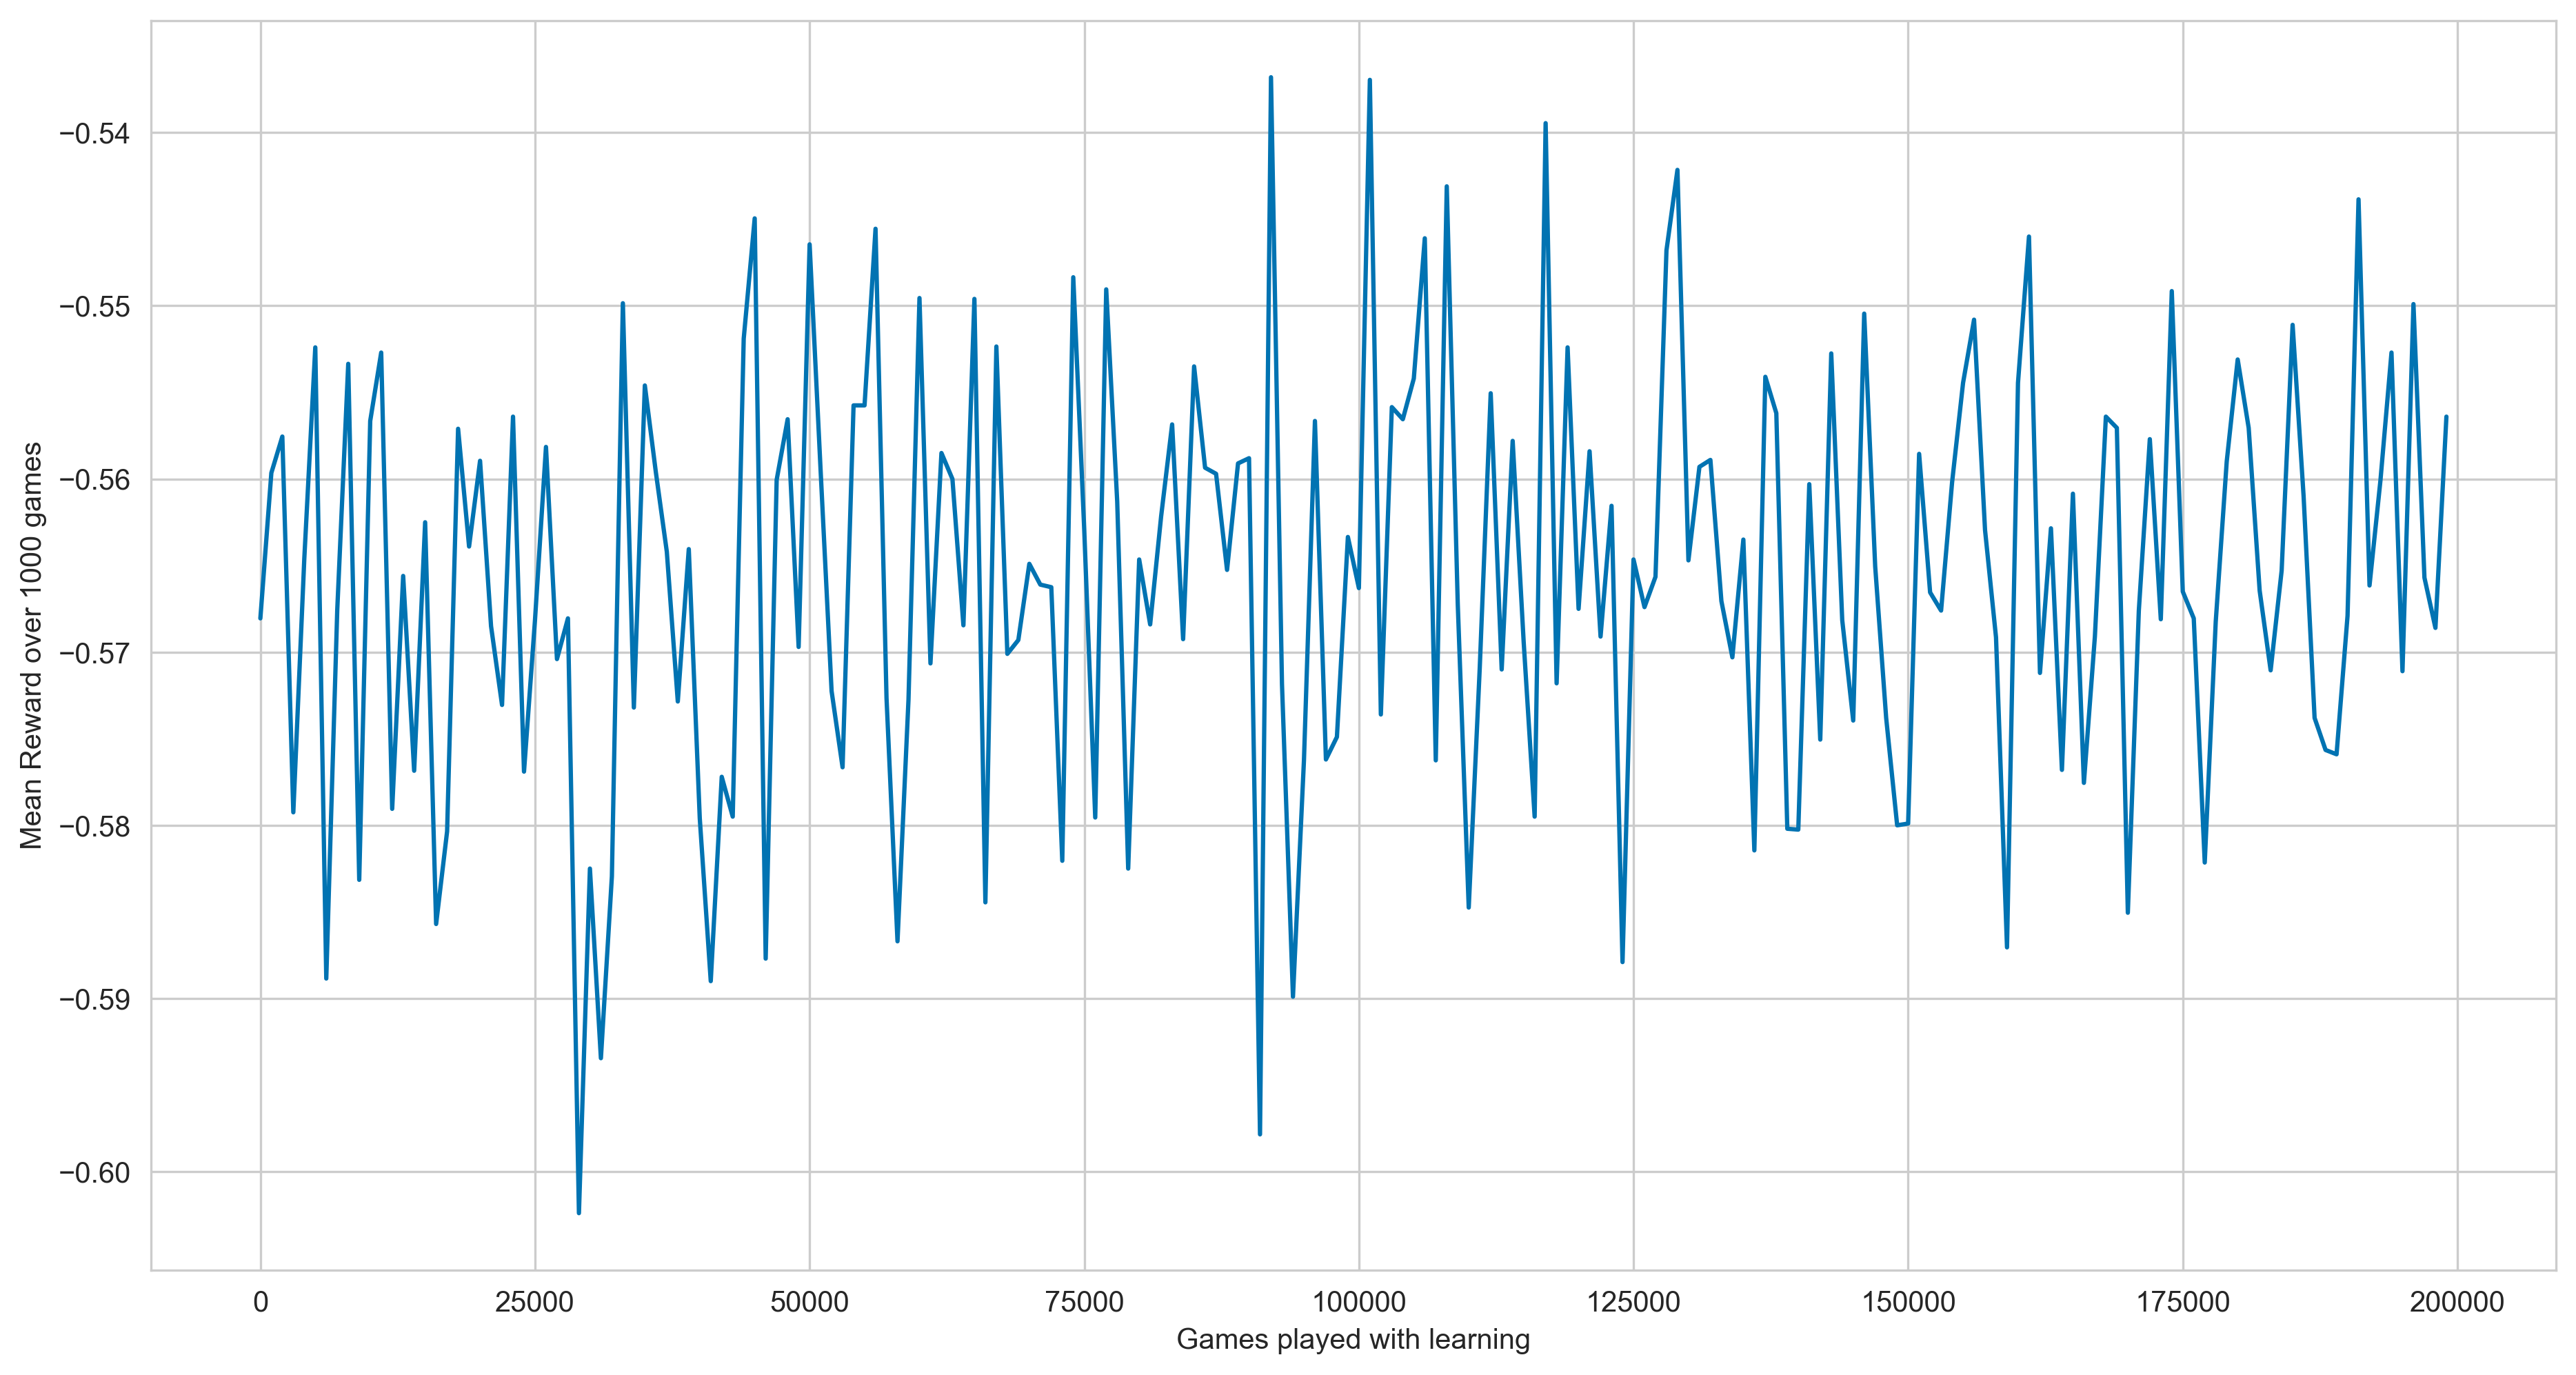

Final agent got mean reward -0.564 for 10000 games


In [120]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.5

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards(reward_list, period)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Final agent got mean reward {res:.3f} for {num_games} games")

env.close()

  0%|          | 0/200000 [00:00<?, ?it/s]

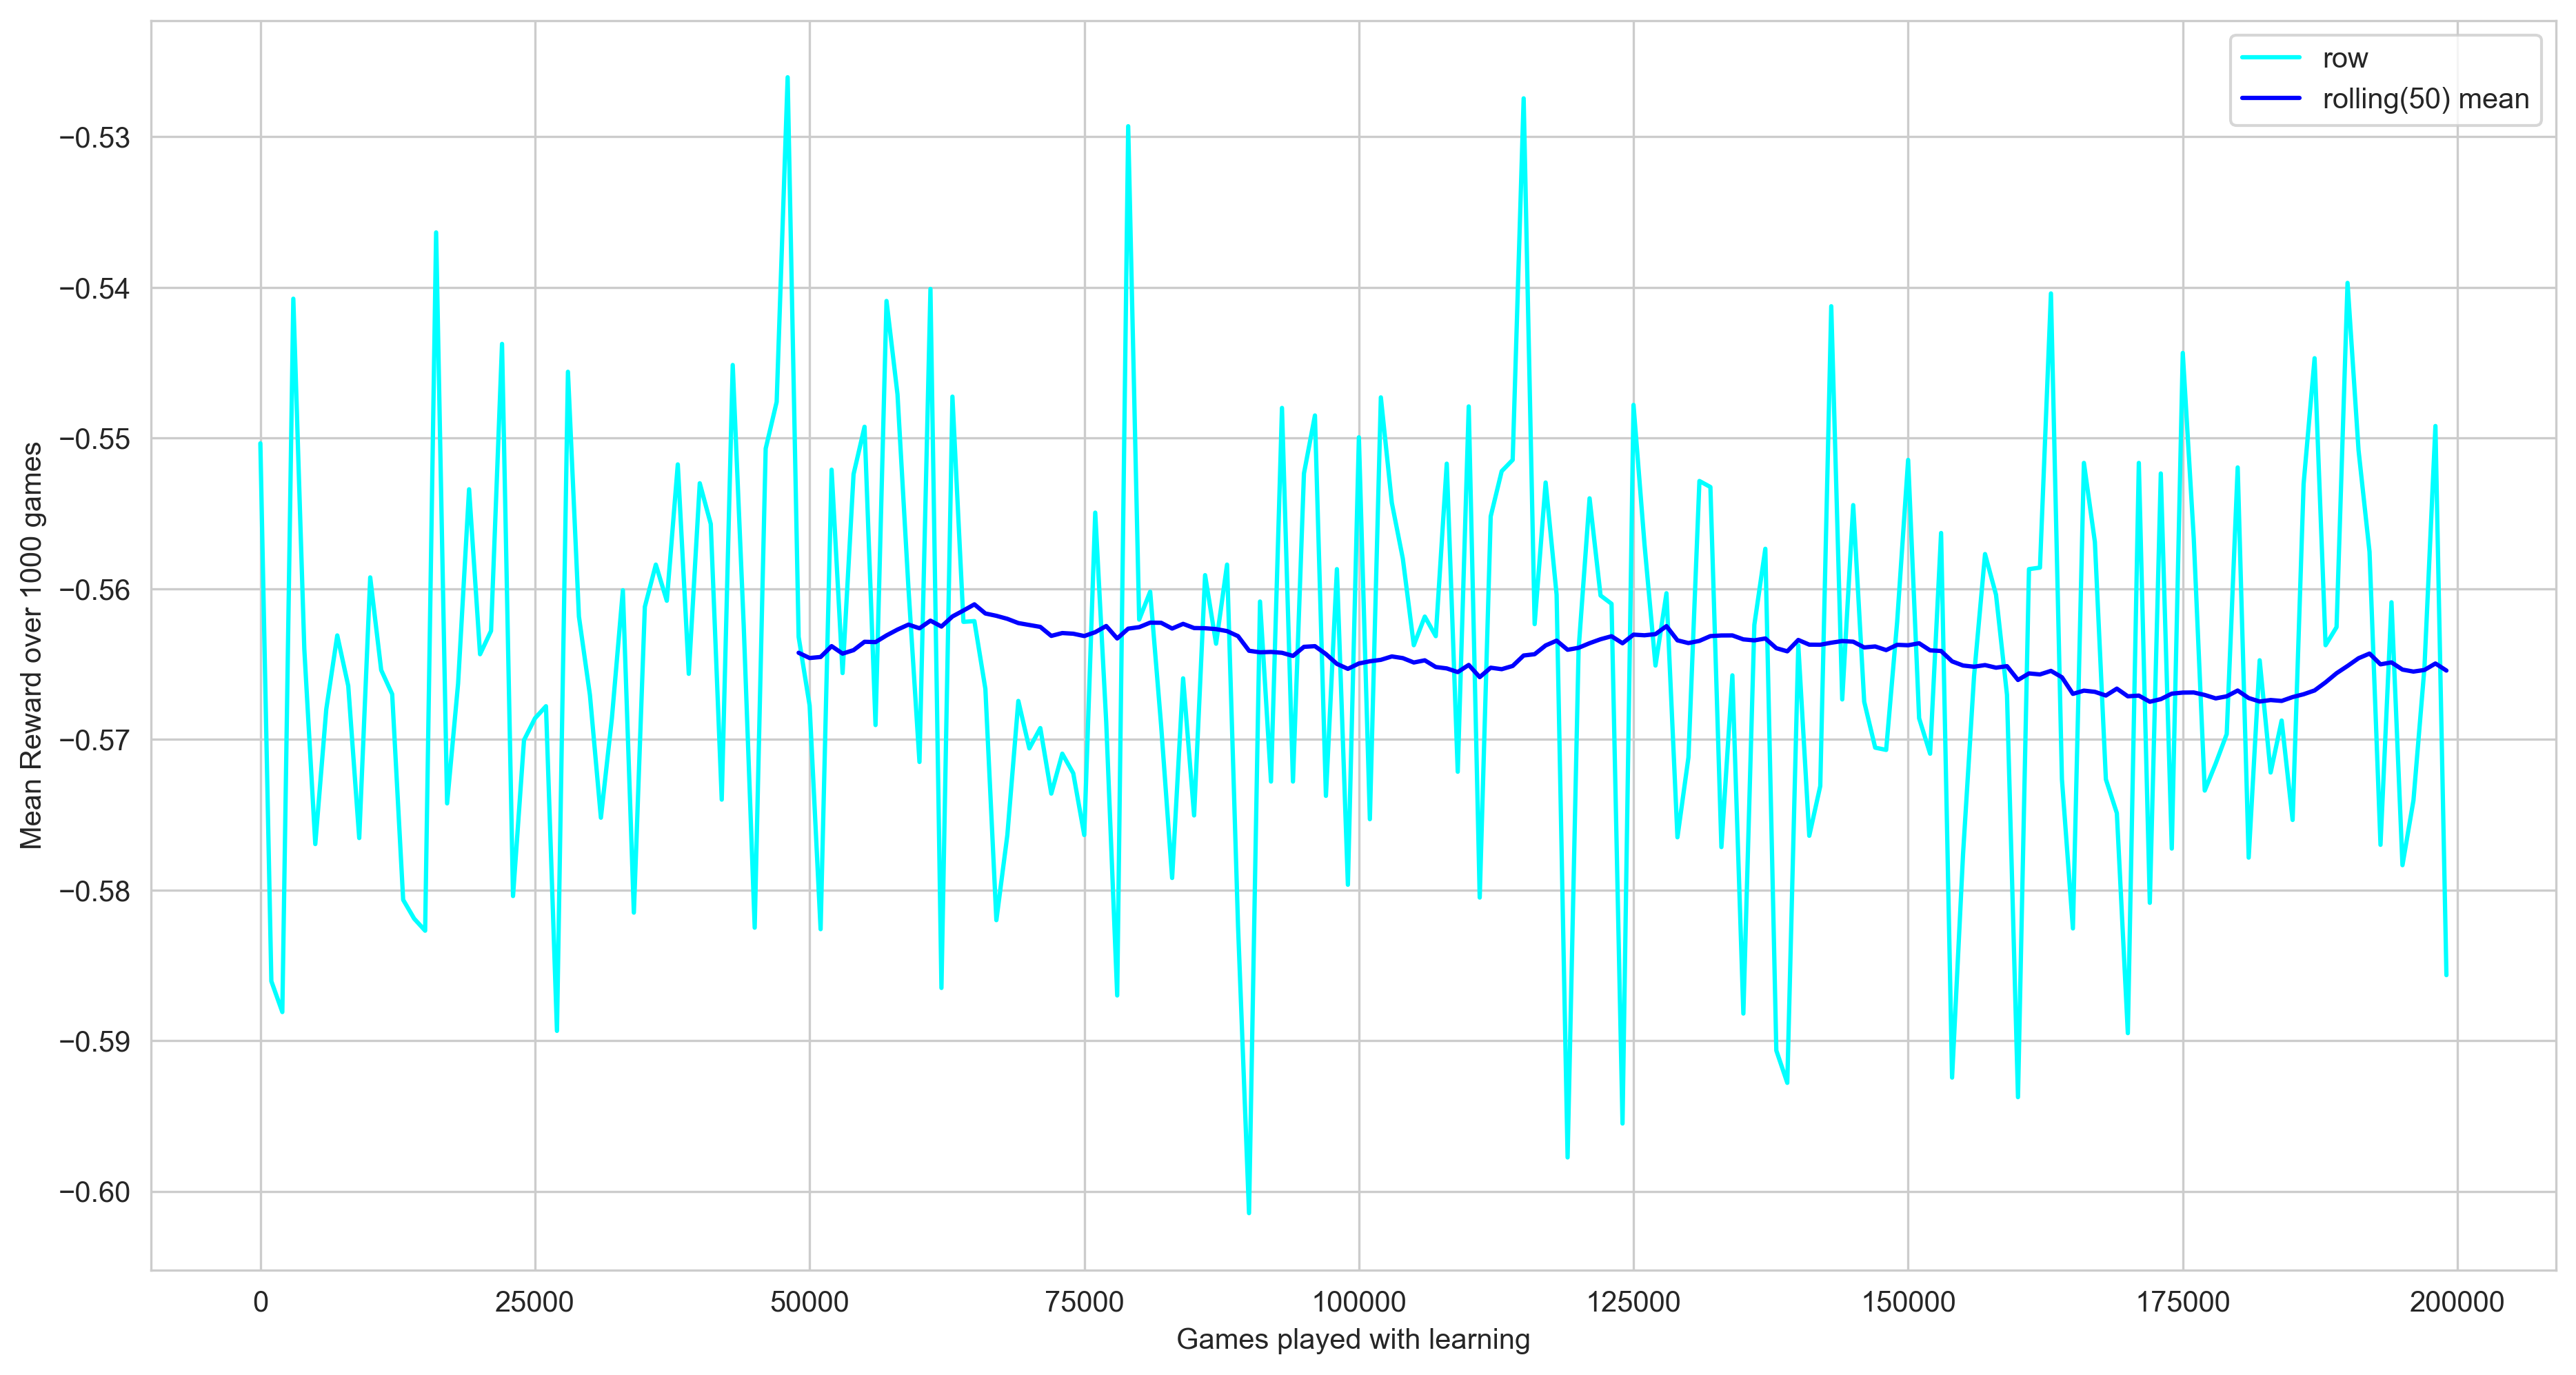

Final agent got mean reward -0.549 for 10000 games


In [94]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 200_000
games_check = 10_000
period = 1_000
gamma = 1
eps = 0.1

agent, reward_list = mc_off_policy_train(env, agent, total_episodes, gamma, eps, period, games_check)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games))
print(f"Final agent got mean reward {res:.3f} for {num_games} games")

env.close()

  0%|          | 0/100000 [00:00<?, ?it/s]

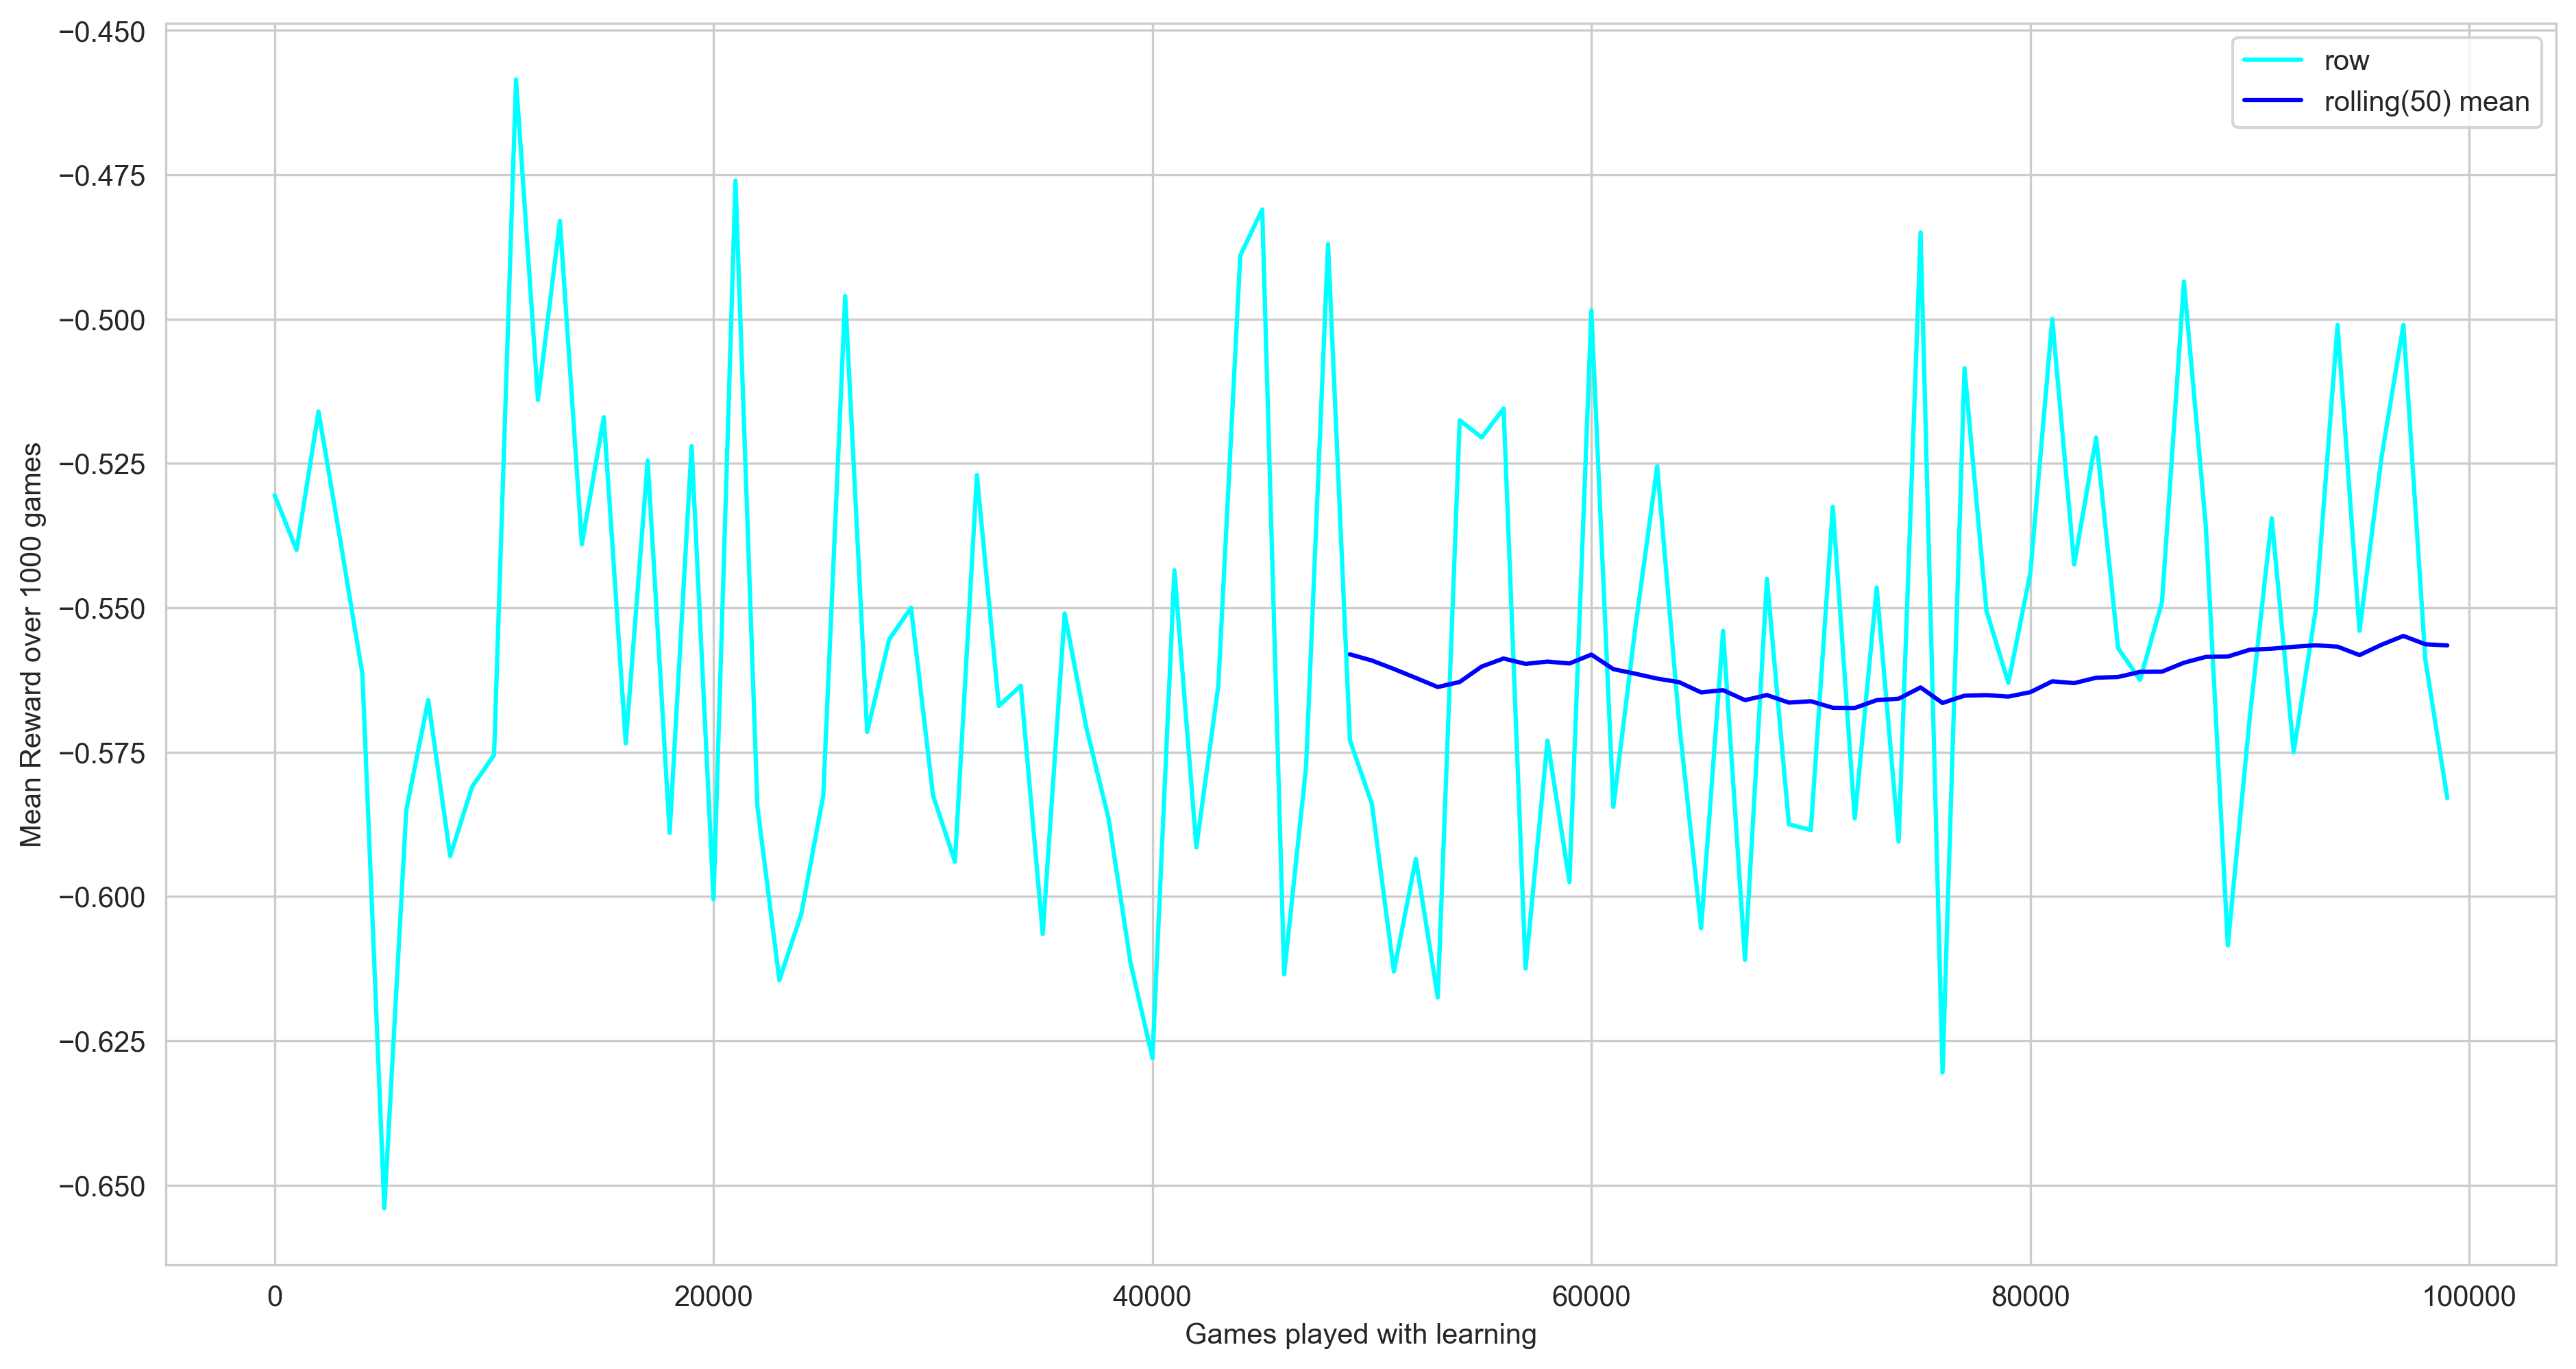

Final agent got mean reward -0.557 for 10000 games


In [125]:
agent = DeterministicPolicyAgent(action_size=nA, states_size=len(state_list))

env = BlackjackDoubleEnv(natural=True, double=True)

# env._max_episode_steps = 10000
total_episodes = 100_000
gamma = 1
eps = 0.95
alpha = 0.01

n_check = 1_000
num_games_inner = 1_000
num_games_outer = 10_000

agent, reward_list = Q_learning_train(env, agent, total_episodes=total_episodes, gamma=gamma,
                                      eps=eps, alpha=alpha, n_check=n_check, num_games=num_games_inner)

plot_rewards_rolling(reward_list, period=n_check, roll=50)

res = np.mean(sample_games(agent, num_games=num_games_outer))
print(f"Final agent got mean reward {res:.3f} for {num_games_outer} games")

env.close()

## Часть третья, в главной роли — Дастин Хоффман

А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.  
Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.  

### 6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии () о блекджеке (а возможно, и нет).  
  
https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

### 7. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.